# Desafio: CNN para Detecção de COVID-19 em Raios-X de Tórax

## Descrição do problema e relevância clínica

Desde o início da pandemia da COVID-19, o diagnóstico rápido e preciso da infecção pelo SARS-CoV-2 tornou-se fundamental para apoiar decisões clínicas e otimizar o uso de recursos hospitalares. O método padrão para detecção do vírus é o exame RT-PCR, reconhecido pela sua confiabilidade, mas limitado por fatores como alto custo, tempo de processamento e disponibilidade restrita em larga escala — especialmente em regiões com infraestrutura limitada.

Nesse contexto, as imagens de raio-X de tórax emergem como uma ferramenta diagnóstica complementar, por serem rápidas, acessíveis e amplamente disponíveis em hospitais. No entanto, a interpretação dessas imagens depende fortemente da experiência do radiologista, o que pode introduzir variabilidade entre diagnósticos humanos.

Diante desse desafio, este projeto propõe o desenvolvimento de um modelo de rede neural convolucional (CNN) capaz de classificar automaticamente imagens de raio-X de tórax em três categorias:

- COVID-19,

- Pneumonia,

- Normal.

O objetivo é construir um sistema de apoio à decisão que auxilie profissionais de saúde na triagem inicial e no acompanhamento de pacientes, contribuindo para diagnósticos mais rápidos e consistentes. Além disso, o projeto aborda aspectos de explicabilidade e ética em IA, explorando visualizações Grad-CAM para identificar as regiões pulmonares mais relevantes nas decisões do modelo — elemento essencial para garantir transparência e confiança no uso de IA em saúde.

## Hipóteses Iniciais

- **Hipótese 1:** As imagens de radiografia de tórax de pacientes com COVID-19 apresentam **padrões radiográficos específicos**, como **opacidades periféricas e infiltrados bilaterais**, que podem ser **detectados e aprendidos por redes neurais convolucionais (CNNs)**, diferenciando-as de casos normais e de pneumonia.

- **Hipótese 2:** Um modelo **CNN devidamente balanceado** e submetido a **técnicas de data augmentation** será capaz de **aprender representações discriminativas** entre as três classes (COVID-19, normal e pneumonia), apresentando **desempenho robusto** em métricas como **acurácia, precisão, sensibilidade e AUC**.

- **Hipótese 3:** O uso de **métodos de explicabilidade baseados em Grad-CAM** permitirá **visualizar as regiões pulmonares mais relevantes** para a decisão do modelo, e essas regiões estarão **coerentes com achados descritos na literatura radiológica**, reforçando a **confiabilidade e interpretabilidade clínica** do sistema.

- **Hipótese 4:** A variabilidade nas resoluções e intensidades das radiografias pode impactar negativamente o desempenho do modelo, tornando essencial a padronização e o pré-processamento das imagens.




## Bibliotecas

In [1]:
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from collections import defaultdict
import pickle
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

## Estrutura e estatísticas do dataset

Foram utilizados conjuntos de dados públicos do Kaggle, ambos contendo imagens de raio-X de tórax com pacientes diagnosticados com COVID-19, pneumonia e casos normais:

- Chest X-ray (COVID-19 & Pneumonia): https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia

- COVID-19 Radiography Database: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
  
- Chest X-Ray (Pneumonia,Covid-19,Tuberculosis): https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis?utm_source=chatgpt.com
  
- Chest Xray for covid-19 detection: https://www.kaggle.com/datasets/fusicfenta/chest-xray-for-covid19-detection?utm_source=chatgpt.com

De alguns datasets foram utilizados somente imagens de COVID-19 para aumentar o numero de amostras, os datasets foram unificados e reorganizados em três classes principais:

- COVID-19

- PNEUMONIA (incluindo Viral Pneumonia e Lung Opacity)

- NORMAL

🔍 Analisando estrutura da base de dados...

📦 Total de imagens encontradas: 28,878
 - Covid     :  5473 imagens ( 19.0%)
 - Normal    : 11775 imagens ( 40.8%)
 - Pneumonia : 11630 imagens ( 40.3%)


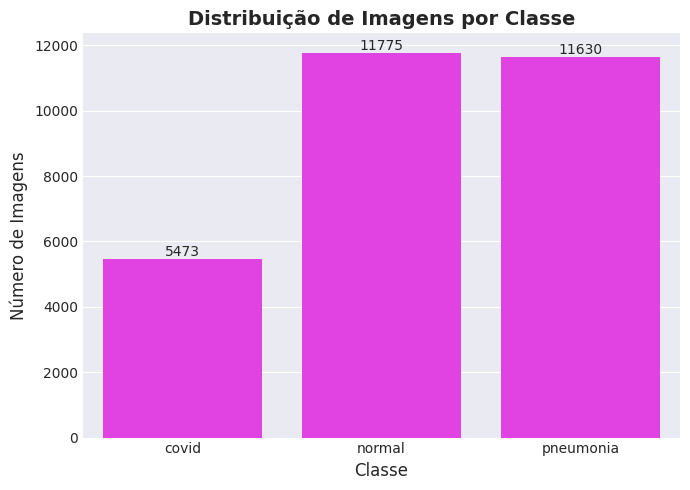


🧩 Interpretação:
 - A base contém 28878 imagens distribuídas em 3 classes.
 - Classe mais representada: 'normal' (11775 imagens)
 - Classe menos representada: 'covid' (5473 imagens)
 - Razão de desbalanceamento: 2.15x
 ⚠️ Desbalanceamento moderado.


In [2]:
# 📊 Estrutura e Estatísticas do Dataset Original

BASE_DIR = "data"              # pasta original
OUTPUT_DIR = "data_split"      # pasta pós-divisão
CLASSES = ["covid", "normal", "pneumonia"]
IMG_EXT = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')

print("🔍 Analisando estrutura da base de dados...\n")

dataset_info = {}

# Conta as imagens em cada subpasta de classe
for c in CLASSES:
    class_path = os.path.join(BASE_DIR, c)
    if not os.path.exists(class_path):
        print(f"⚠️ Pasta '{class_path}' não encontrada!")
        continue
    
    n_images = len([f for f in os.listdir(class_path) if f.lower().endswith(IMG_EXT)])
    dataset_info[c] = n_images


#  Estatísticas Resumidas

total_images = sum(dataset_info.values())
print(f"📦 Total de imagens encontradas: {total_images:,}")

for c, n in dataset_info.items():
    pct = (n / total_images) * 100
    print(f" - {c.capitalize():10}: {n:5d} imagens ({pct:5.1f}%)")


# Visualização Gráfica

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette(['#fb27fd', '#41ecf0', '#6f2ed0'])

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=list(dataset_info.keys()), y=list(dataset_info.values()), ax=ax)

ax.bar_label(ax.containers[0], fmt='%d', label_type='edge', fontsize=10)
ax.set_xlabel("Classe", fontsize=12)
ax.set_ylabel("Número de Imagens", fontsize=12)
ax.set_title("Distribuição de Imagens por Classe", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Interpretação

max_class = max(dataset_info, key=dataset_info.get)
min_class = min(dataset_info, key=dataset_info.get)
ratio = dataset_info[max_class] / dataset_info[min_class]

print("\n🧩 Interpretação:")
print(f" - A base contém {total_images} imagens distribuídas em {len(CLASSES)} classes.")
print(f" - Classe mais representada: '{max_class}' ({dataset_info[max_class]} imagens)")
print(f" - Classe menos representada: '{min_class}' ({dataset_info[min_class]} imagens)")
print(f" - Razão de desbalanceamento: {ratio:.2f}x")

if ratio > 5:
    print(" ⚠️ Desbalanceamento crítico detectado.")
elif ratio > 2:
    print(" ⚠️ Desbalanceamento moderado.")
else:
    print(" ✅ Distribuição relativamente equilibrada entre classes.")


# Preparação dos Dados para Classificação de Imagens

Esta etapa é responsável por preparar o conjunto de dados de imagens para o treinamento dos modelos de *Deep Learning*, garantindo consistência, balanceamento e padronização.  
Os dados utilizados estão organizados em três subconjuntos: **train**, **validation** e **test**, 70% / 15% / 15%,  mantém avaliação consistente do desempenho do modelo, limitado em 5473 imagens para ter uma balanceamento melhor entre as classes, respeitando a estrutura esperada pelo Keras `ImageDataGenerator`.

---

## Relevância do Código

A preparação adequada dos dados é fundamental para o sucesso de modelos de classificação de imagens.  
Esse trecho do código implementa um **pipeline completo de carregamento e pré-processamento**, com os seguintes objetivos principais:

- **Garantir padronização** das imagens (mesmo tamanho, formato e modo de cor).  
- **Aplicar data augmentation** durante o treinamento, aumentando a robustez e reduzindo o overfitting.  
- **Ajustar o pré-processamento conforme o tipo de modelo**:  
  - CNN do zero → imagens em escala de cinza, normalização 0–1.  
  - ResNet50 → imagens RGB com normalização específica da rede.  
- **Calcular pesos de classe balanceados**, compensando eventuais desproporções no número de amostras de cada classe.

Essas configurações asseguram que o modelo receba dados limpos, equilibrados e com variabilidade suficiente para generalizar bem.

---

## Explicação das Configurações

- **`ImageDataGenerator`**  
  É usado para gerar lotes de imagens com transformações aleatórias em tempo real, permitindo aumentar a diversidade do dataset sem criar novos arquivos.  
  As transformações aplicadas incluem:
  - `rotation_range`, `width_shift_range`, `height_shift_range`: simulam pequenas variações espaciais.  
  - `zoom_range`: altera o campo de visão da imagem.  
  - `horizontal_flip`: inverte horizontalmente as imagens, útil para aprendizado invariante à orientação.  
  - `rescale=1./255`: normaliza os valores de pixel para o intervalo [0, 1].

- **`get_generators()`**  
  Cria automaticamente os geradores de imagens para treino, validação e teste, adaptando o modo de cor e o tipo de pré-processamento conforme o modelo selecionado.  
  Isso permite alternar facilmente entre diferentes arquiteturas (ex.: CNN do zero vs. ResNet50).

- **`compute_class_weight()`**  
  Calcula os pesos de cada classe com base em sua frequência, garantindo que classes menos representadas tenham impacto proporcional no treinamento.  
  Essa abordagem é essencial quando há **desbalanceamento entre classes** (por exemplo, menos imagens de COVID-19 em relação a "normal").

---

## Importância da Aplicabilidade

A aplicabilidade prática desse código está em tornar o treinamento:
- **mais estável**, ao controlar o balanceamento de classes;  
- **mais robusto**, graças à variação sintética das imagens;  
- **mais escalável**, ao permitir o uso do mesmo pipeline com diferentes arquiteturas de rede.  

Além disso, o uso de *data generators* permite processar grandes volumes de imagens **sem carregar tudo na memória**, o que é essencial em ambientes com limitação de recursos.

---

## Conclusão

A preparação e padronização dos dados garantem a **qualidade do aprendizado** e **a comparabilidade entre modelos**.  
Esse código constitui uma base sólida para experimentos reprodutíveis e escaláveis em tarefas de **classificação de imagens médicas**, como a detecção de **COVID-19, pneumonia e casos normais** a partir de radiografias de tórax.


In [ ]:
# ==============================
# ⚙️ CONFIGURAÇÕES INICIAIS
# ==============================
random.seed(42)

BASE_DIR = "data"              # pasta original
OUTPUT_DIR = "data_split"      # nova estrutura balanceada
CLASSES = ["covid", "normal", "pneumonia"]
IMG_EXT = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')

N_IMAGENS_POR_CLASSE = 5473
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.7, 0.15, 0.15

# ==============================
# 🧩 FUNÇÃO AUXILIAR
# ==============================
def limpar_e_criar_pastas():
    """Remove pastas antigas e cria nova estrutura limpa."""
    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)
    for subset in ["train", "val", "test"]:
        for classe in CLASSES:
            os.makedirs(os.path.join(OUTPUT_DIR, subset, classe), exist_ok=True)

# ==============================
# 🚀 SEPARAÇÃO DOS DADOS
# ==============================
limpar_e_criar_pastas()

for classe in CLASSES:
    classe_path = os.path.join(BASE_DIR, classe)
    imagens = [f for f in os.listdir(classe_path) if f.lower().endswith(IMG_EXT)]
    
    if len(imagens) == 0:
        print(f"⚠️ Nenhuma imagem encontrada na classe {classe}")
        continue
    
    # embaralha e limita ao número desejado
    random.shuffle(imagens)
    imagens = imagens[:N_IMAGENS_POR_CLASSE]
    
    # calcula quantidades
    n_train = int(TRAIN_RATIO * N_IMAGENS_POR_CLASSE)
    n_val = int(VAL_RATIO * N_IMAGENS_POR_CLASSE)
    
    splits = {
        "train": imagens[:n_train],
        "val": imagens[n_train:n_train + n_val],
        "test": imagens[n_train + n_val:]
    }
    
    # copia os arquivos
    for subset, files in splits.items():
        destino = os.path.join(OUTPUT_DIR, subset, classe)
        for fname in tqdm(files, desc=f"📂 Copiando {classe} → {subset}", leave=False):
            shutil.copy(os.path.join(classe_path, fname), os.path.join(destino, fname))

print("\n✅ Separação concluída com sucesso!")
print(f"Todas as classes balanceadas com {N_IMAGENS_POR_CLASSE} imagens cada.")

# ==============================
# 📊 VERIFICAÇÃO FINAL
# ==============================
resumo = {}

for subset in ["train", "val", "test"]:
    print(f"\n📁 {subset.upper()}")
    print("=" * 30)
    total_subset = 0
    for classe in CLASSES:
        subset_path = os.path.join(OUTPUT_DIR, subset, classe)
        count = len([f for f in os.listdir(subset_path) if f.lower().endswith(IMG_EXT)])
        resumo[(subset, classe)] = count
        total_subset += count
        print(f"   {classe:<10} : {count:4d}")
    print(f"   TOTAL: {total_subset}")

print("\n📈 Estrutura final criada em:", os.path.abspath(OUTPUT_DIR))


In [3]:
# CLASSIFICAÇÃO DE IMAGENS
plt.style.use('seaborn-v0_8')

# CONFIGURAÇÕES BÁSICAS

base_dir = "data_split"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
NUM_CLASSES = 3

print("✅ TensorFlow version:", tf.__version__)
print("🧩 GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

# Gerador base para CNN do zero (usa normalização simples)
train_datagen_cnn = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen_cnn = ImageDataGenerator(rescale=1./255)

# Geradores com pré-processamento específico de cada rede
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen_resnet = ImageDataGenerator(preprocessing_function=resnet_preprocess)

# FUNÇÃO PARA GERAR OS DADOS

def get_generators(model_type="cnn"):
    """
    Cria os geradores corretos dependendo do modelo escolhido:
    - 'cnn' -> CNN do zero (grayscale, normalização 0–1)
    - 'resnet' -> ResNet50 (RGB + pré-processamento ResNet)
    """
    if model_type == "resnet":
        train_datagen = train_datagen_resnet
        val_test_datagen = val_test_datagen_resnet
        color_mode = 'rgb'
    else:
        train_datagen = train_datagen_cnn
        val_test_datagen = val_test_datagen_cnn
        color_mode = 'grayscale'  

    train_gen = train_datagen.flow_from_directory(
        os.path.join(base_dir, "train"),
        target_size=IMG_SIZE,
        color_mode=color_mode,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )

    val_gen = val_test_datagen.flow_from_directory(
        os.path.join(base_dir, "val"),
        target_size=IMG_SIZE,
        color_mode=color_mode,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        seed=SEED
    )

    test_gen = val_test_datagen.flow_from_directory(
        os.path.join(base_dir, "test"),
        target_size=IMG_SIZE,
        color_mode=color_mode,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        seed=SEED
    )

    print(f"\n📂 Classes detectadas: {train_gen.class_indices}")
    print(f"🎨 Modo de cor usado: {color_mode.upper()}")
    return train_gen, val_gen, test_gen

# PESOS DE CLASSE

# Calcula uma vez (é o mesmo independente do modelo)
temp_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(temp_gen.classes),
    y=temp_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("\n⚖️ Pesos de classe aplicados:", class_weights)


✅ TensorFlow version: 2.16.1
🧩 GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 11493 images belonging to 3 classes.

⚖️ Pesos de classe aplicados: {0: 1.0, 1: 1.0, 2: 1.0}


# Análise Exploratória de Dados (EDA) – Relevância e Aplicabilidade

A **Análise Exploratória de Dados (EDA)** desenvolvida neste código tem como objetivo compreender a estrutura, qualidade e distribuição do conjunto de imagens utilizado no projeto de classificação com redes neurais convolucionais (CNN).

Antes do treinamento de qualquer modelo de *Deep Learning*, é fundamental conhecer a natureza dos dados — tanto de forma **quantitativa** (quantidade de imagens por classe, proporção entre conjuntos) quanto **qualitativa** (resolução, cores, textura e intensidade).  
Essa etapa garante a **integridade e consistência dos dados**, permitindo a definição de estratégias adequadas de **pré-processamento** e **balanceamento**.

---

## Relevância Técnica

A EDA executada neste projeto fornece uma visão completa e interpretável do dataset, contemplando:

- **Distribuição e balanceamento** entre as classes nos conjuntos de treino, validação e teste → essencial para evitar viés de aprendizado.
- **Propriedades físicas das imagens** (resolução, aspect ratio, modo de cor) → importantes para padronização do pipeline de entrada.
- **Análise de intensidade e textura** → auxilia na identificação de padrões visuais relevantes e diferenças entre classes.
- **Visualização de amostras representativas** → garante a coerência visual e a ausência de dados ruidosos ou corrompidos.
- **Resumo estatístico consolidado** → sintetiza as principais métricas, orientando decisões sobre normalização e augmentação.

---

## Importância da Aplicabilidade

A aplicabilidade prática dessa análise está em sua capacidade de **diagnosticar e antecipar problemas** que podem comprometer o desempenho do modelo de aprendizado profundo.  
Por exemplo:

- Detectar **desbalanceamento de classes**, reduzindo o risco de viés na predição.  
- Identificar **inconsistências estruturais** (tamanho, cor, proporção) que impactam o treinamento da CNN.  
- Avaliar **características visuais diferenciadoras** (entropia e contraste), fundamentais para compreender a separabilidade entre classes.

Além disso, essa EDA contribui para a **rastreabilidade e documentação do pipeline de dados**, atendendo boas práticas de engenharia de software e ciência de dados.  
Isso é particularmente relevante em contextos de **pesquisa aplicada**, **auditoria de modelos** e **reprodutibilidade experimental**.

---

## Conclusão

A EDA não é apenas uma etapa exploratória, mas um **componente estratégico do ciclo de vida do modelo**.  
Ela assegura que o aprendizado ocorra sobre dados **confiáveis, padronizados e representativos**, aumentando a **explicabilidade**, **robustez** e **qualidade** dos resultados.

O código desenvolvido fornece uma análise abrangente e interpretável do dataset, sendo crucial para projetos de **classificação de imagens médicas** como o de **detecção de COVID-19, pneumonia e casos normais em radiografias de tórax**, garantindo maior confiança e validade científica ao modelo treinado.



🔄 Iniciando EDA completa e interpretada...

📊 Analisando distribuição de imagens...


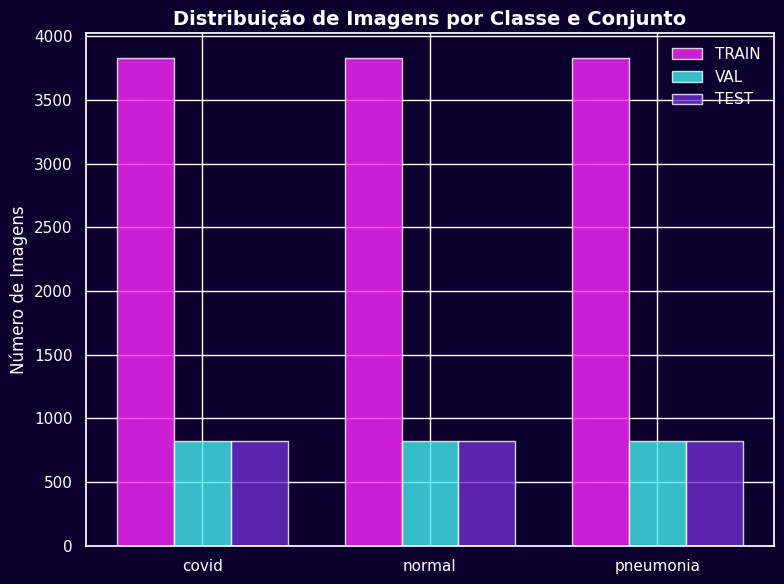

🔍 Interpretação:
 - Verifique se há desbalanceamento significativo entre classes.
 - Diferenças grandes (>2x) podem exigir técnicas de augmentação ou ponderação de perda.

📐 Analisando propriedades estruturais...


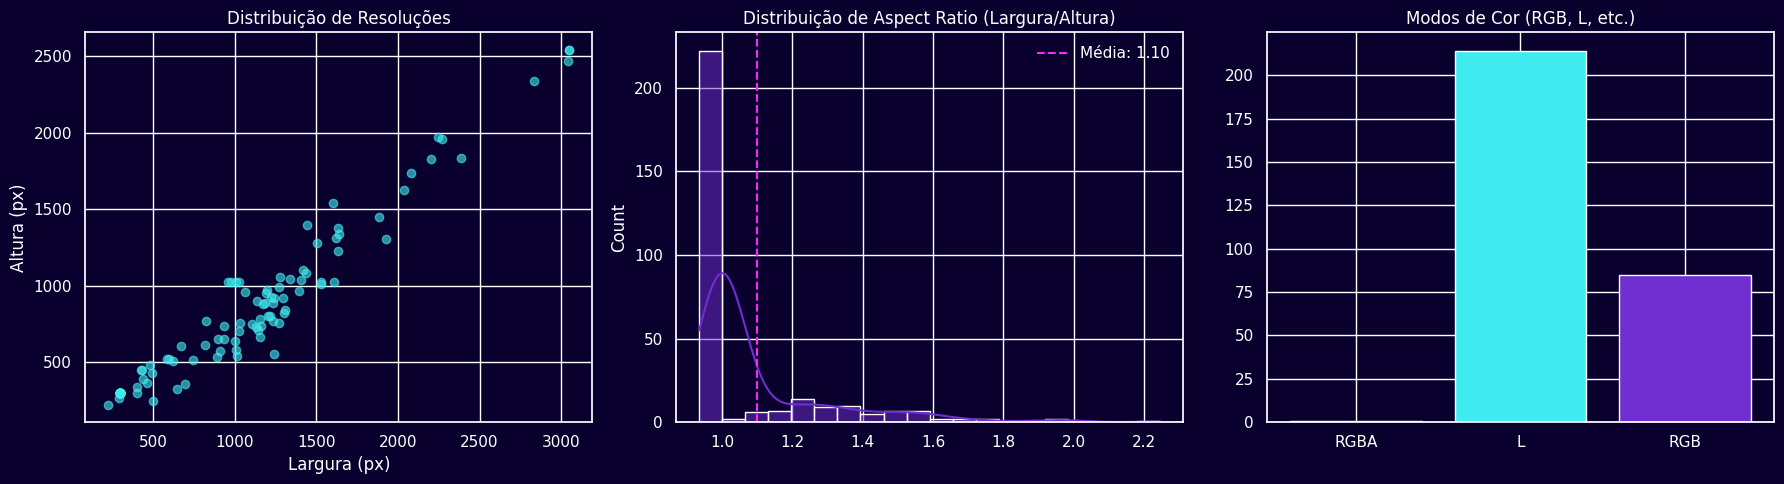

🔍 Interpretação:
 - Verifique se as resoluções são homogêneas (importante para padronização).
 - Aspect ratios muito variados indicam necessidade de crop/pad.
 - Modos diferentes (ex: RGB vs L) devem ser uniformizados antes do treino.

🎨 Avaliando intensidade e textura...


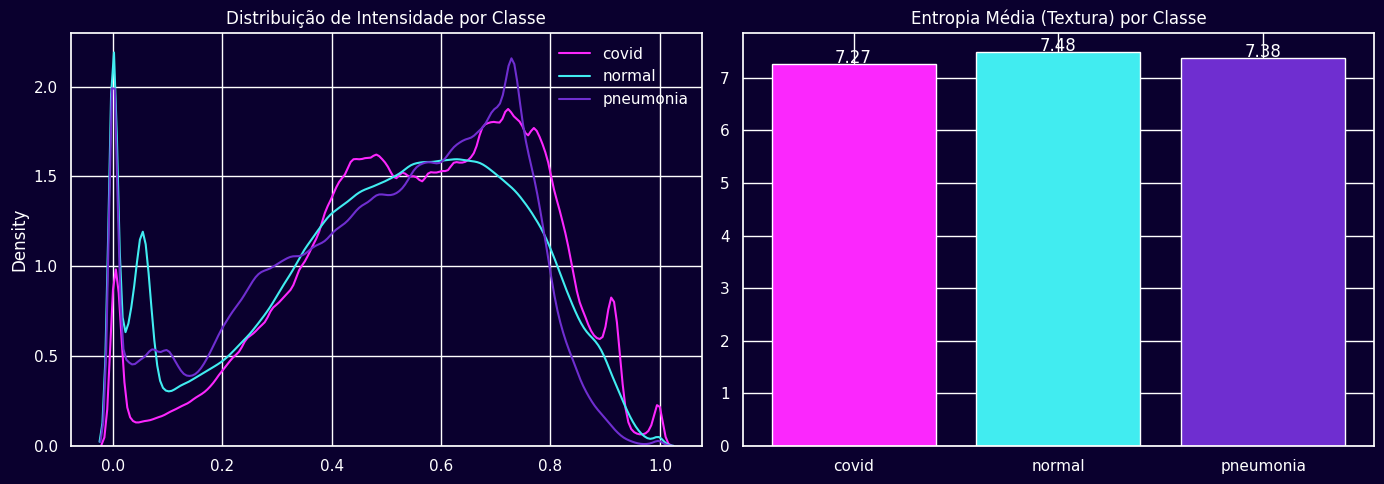

🔍 Interpretação:
 - A intensidade média indica o brilho médio das imagens (útil para normalização).
 - A entropia reflete a complexidade visual — classes com entropia alta têm mais textura.

🖼️ Visualizando amostras por classe...


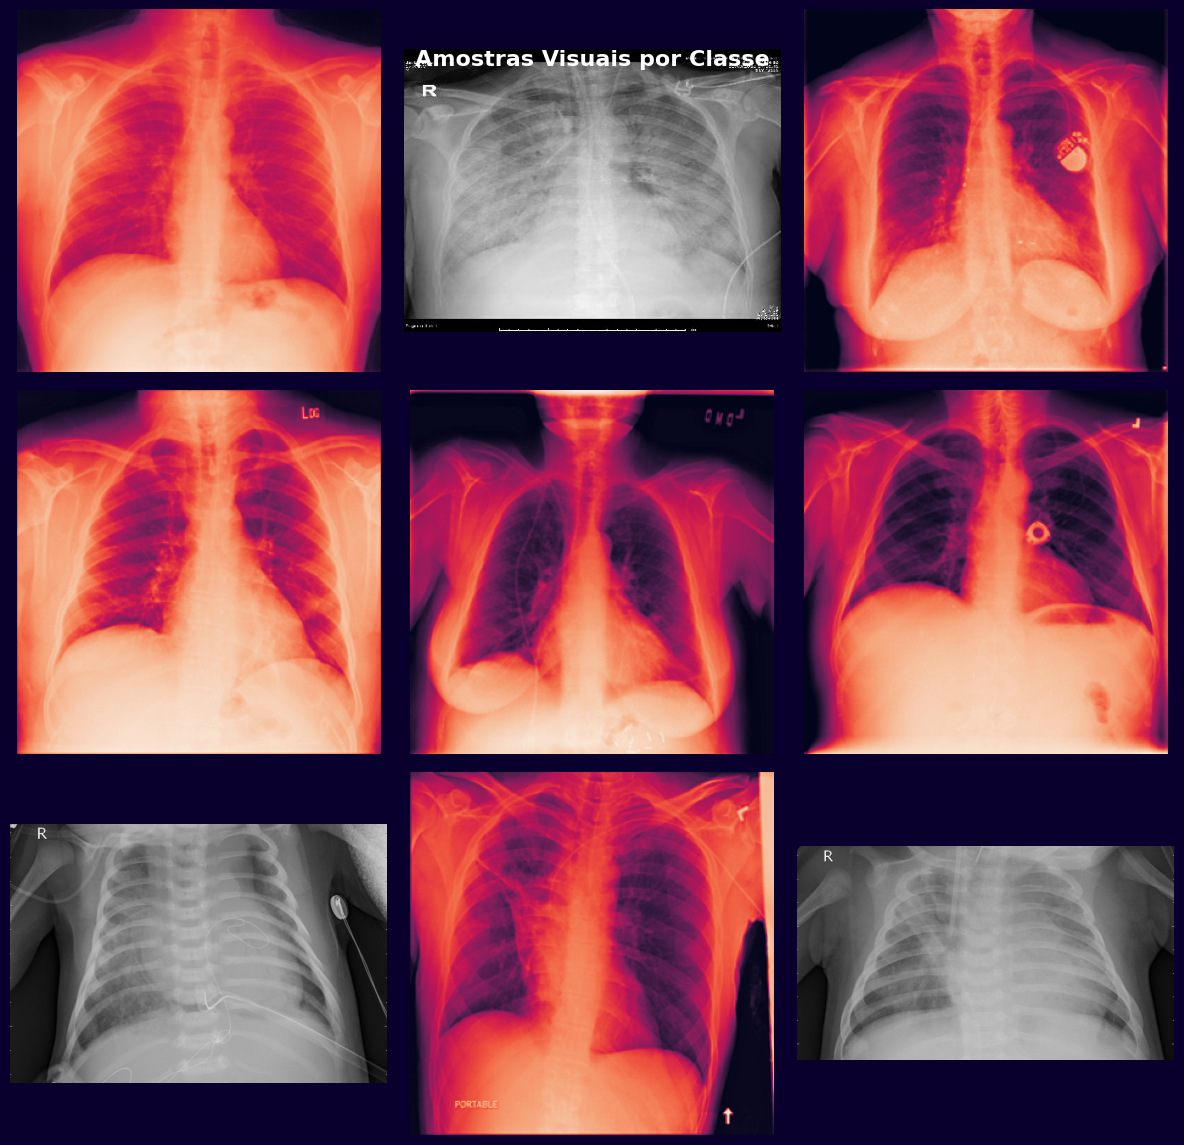

🔍 Interpretação:
 - Permite identificar imagens corrompidas, ruídos, legendas, duplicatas ou padrões visuais.
 - Essencial para validar a qualidade visual e coerência do dataset.

📋 RESUMO ESTATÍSTICO E INTERPRETAÇÃO FINAL

TRAIN: 11493 imagens
 - covid     : 3831 ( 33.3%)
 - normal    : 3831 ( 33.3%)
 - pneumonia : 3831 ( 33.3%)

VAL: 2460 imagens
 - covid     :  820 ( 33.3%)
 - normal    :  820 ( 33.3%)
 - pneumonia :  820 ( 33.3%)

TEST: 2466 imagens
 - covid     :  822 ( 33.3%)
 - normal    :  822 ( 33.3%)
 - pneumonia :  822 ( 33.3%)

⚖️  Razão de desbalanceamento (treino): 1.00x
   ✅ Classes razoavelmente equilibradas.

📐 Resolução média: 567×485 px | Aspect Ratio médio: 1.10
🎨 Intensidade média (global): 0.516
🧩 Entropia média (global): 7.376

✅ EDA completa concluída com sucesso!


In [4]:
# EDA COMPLETA — Conjuntos de Imagens (CNN)

# Configurações visuais

plt.style.use('default')
sns.set_theme(style="darkgrid")
plt.rcParams.update({
    'axes.facecolor': '#0A002E',
    'figure.facecolor': '#0A002E',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'text.color': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'legend.frameon': False
})

colors = ['#fb27fd', '#41ecf0', '#6f2ed0']

base_dir = "data_split"
sets = ["train", "val", "test"]
classes = ["covid", "normal", "pneumonia"]

print("🔄 Iniciando EDA completa e interpretada...\n")


# DISTRIBUIÇÃO E BALANCEAMENTO

print("📊 Analisando distribuição de imagens...")

class_counts = {}
for s in sets:
    class_counts[s] = {c: len(os.listdir(os.path.join(base_dir, s, c))) for c in classes}

fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(len(classes))
width = 0.25
for i, s in enumerate(sets):
    ax.bar(x + i * width, [class_counts[s][c] for c in classes],
           width=width, label=s.upper(), color=colors[i], alpha=0.8)

ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.set_ylabel("Número de Imagens")
ax.set_title("Distribuição de Imagens por Classe e Conjunto", fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

print("🔍 Interpretação:")
print(" - Verifique se há desbalanceamento significativo entre classes.")
print(" - Diferenças grandes (>2x) podem exigir técnicas de augmentação ou ponderação de perda.\n")

# PROPRIEDADES DAS IMAGENS

print("📐 Analisando propriedades estruturais...")

def analyze_image_properties(base_dir, classes, sample_size=100):
    widths, heights, ratios, modes = [], [], [], []
    for c in classes:
        path = os.path.join(base_dir, "train", c)
        imgs = [f for f in os.listdir(path) if f.lower().endswith(('jpg','png','jpeg'))]
        for img_file in random.sample(imgs, min(sample_size, len(imgs))):
            img = Image.open(os.path.join(path, img_file))
            w, h = img.size
            widths.append(w)
            heights.append(h)
            ratios.append(w/h)
            modes.append(img.mode)
    return widths, heights, ratios, modes

widths, heights, ratios, modes = analyze_image_properties(base_dir, classes)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Resoluções
axes[0].scatter(widths, heights, color=colors[1], alpha=0.6)
axes[0].set_xlabel("Largura (px)")
axes[0].set_ylabel("Altura (px)")
axes[0].set_title("Distribuição de Resoluções")

# Aspect Ratio
sns.histplot(ratios, bins=20, kde=True, color=colors[2], ax=axes[1])
axes[1].axvline(np.mean(ratios), color=colors[0], linestyle='--', label=f"Média: {np.mean(ratios):.2f}")
axes[1].set_title("Distribuição de Aspect Ratio (Largura/Altura)")
axes[1].legend()

# Modos de cor
mode_counts = {m: modes.count(m) for m in set(modes)}
axes[2].bar(mode_counts.keys(), mode_counts.values(), color=colors)
axes[2].set_title("Modos de Cor (RGB, L, etc.)")

plt.tight_layout()
plt.show()

print("🔍 Interpretação:")
print(" - Verifique se as resoluções são homogêneas (importante para padronização).")
print(" - Aspect ratios muito variados indicam necessidade de crop/pad.")
print(" - Modos diferentes (ex: RGB vs L) devem ser uniformizados antes do treino.\n")

# INTENSIDADE E TEXTURA

print("🎨 Avaliando intensidade e textura...")

def analyze_intensity_texture(base_dir, classes, n=50):
    stats = {}
    for c in classes:
        imgs = [f for f in os.listdir(os.path.join(base_dir, "train", c)) if f.lower().endswith(('jpg','png','jpeg'))]
        intensities, entropies = [], []
        for img_file in random.sample(imgs, min(n, len(imgs))):
            img = cv2.imread(os.path.join(base_dir, "train", c, img_file), cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            intensities.extend(img.flatten() / 255)
            hist = cv2.calcHist([img], [0], None, [256], [0, 256]) / img.size
            entropy = -np.sum(hist * np.log2(hist + 1e-9))
            entropies.append(entropy)
        stats[c] = {
            "mean_intensity": np.mean(intensities),
            "entropy_mean": np.mean(entropies),
            "intensity_values": intensities
        }
    return stats

stats = analyze_intensity_texture(base_dir, classes)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de intensidade
for i, c in enumerate(classes):
    sns.kdeplot(stats[c]["intensity_values"], label=c, color=colors[i], ax=axes[0])
axes[0].set_title("Distribuição de Intensidade por Classe")
axes[0].legend()

# Entropia
axes[1].bar(classes, [stats[c]["entropy_mean"] for c in classes], color=colors)
axes[1].set_title("Entropia Média (Textura) por Classe")
for i, c in enumerate(classes):
    axes[1].text(i, stats[c]["entropy_mean"] + 0.02, f"{stats[c]['entropy_mean']:.2f}", ha="center")

plt.tight_layout()
plt.show()

print("🔍 Interpretação:")
print(" - A intensidade média indica o brilho médio das imagens (útil para normalização).")
print(" - A entropia reflete a complexidade visual — classes com entropia alta têm mais textura.\n")

# AMOSTRAS REPRESENTATIVAS

print("🖼️ Visualizando amostras por classe...")

def display_samples(base_dir, classes, n=3):
    fig, axes = plt.subplots(len(classes), n, figsize=(4*n, 4*len(classes)))
    for i, c in enumerate(classes):
        imgs = os.listdir(os.path.join(base_dir, "train", c))
        for j, img_file in enumerate(random.sample(imgs, n)):
            img = Image.open(os.path.join(base_dir, "train", c, img_file))
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_ylabel(c.upper(), fontsize=12, fontweight='bold')
    plt.suptitle("Amostras Visuais por Classe", fontsize=16, fontweight='bold', y=1)
    plt.tight_layout()
    plt.show()

display_samples(base_dir, classes)

print("🔍 Interpretação:")
print(" - Permite identificar imagens corrompidas, ruídos, legendas, duplicatas ou padrões visuais.")
print(" - Essencial para validar a qualidade visual e coerência do dataset.\n")

# RESUMO ESTATÍSTICO

print("="*60)
print("📋 RESUMO ESTATÍSTICO E INTERPRETAÇÃO FINAL")
print("="*60)

for s in sets:
    total = sum(class_counts[s].values())
    print(f"\n{ s.upper() }: {total} imagens")
    for c in classes:
        pct = (class_counts[s][c] / total) * 100
        print(f" - {c:10}: {class_counts[s][c]:4d} ({pct:5.1f}%)")

ratio = max(class_counts['train'].values()) / min(class_counts['train'].values())
print(f"\n⚖️  Razão de desbalanceamento (treino): {ratio:.2f}x")

if ratio > 5:
    print("   ⚠️ Desbalanceamento crítico.")
elif ratio > 2:
    print("   ⚠️ Desbalanceamento moderado.")
else:
    print("   ✅ Classes razoavelmente equilibradas.")

print(f"\n📐 Resolução média: {np.mean(widths):.0f}×{np.mean(heights):.0f} px | Aspect Ratio médio: {np.mean(ratios):.2f}")
print(f"🎨 Intensidade média (global): {np.mean([stats[c]['mean_intensity'] for c in classes]):.3f}")
print(f"🧩 Entropia média (global): {np.mean([stats[c]['entropy_mean'] for c in classes]):.3f}")

print("\n✅ EDA completa concluída com sucesso!")


# Resumo Estatístico e Interpretação Final

A análise exploratória indica que o dataset está **bem estruturado e balanceado** entre as três classes (*COVID-19*, *Normal* e *Pneumonia*), apresentando distribuição igualitária em todos os subconjuntos (**train**, **validation** e **test**).

---

## Estrutura do Dataset

| Conjunto | Total de Imagens | COVID-19 | Normal | Pneumonia |
|-----------|-----------------|-----------|---------|------------|
| **Train** | 11.493 | 3.831 (33,3%) | 3.831 (33,3%) | 3.831 (33,3%) |
| **Validation** | 2.460 | 820 (33,3%) | 820 (33,3%) | 820 (33,3%) |
| **Test** | 2.466 | 822 (33,3%) | 822 (33,3%) | 822 (33,3%) |

✅ **Razão de desbalanceamento (treino): 1.00x**  
→ Classes perfeitamente equilibradas, não sendo necessária aplicação de técnicas de compensação.

---

## Estatísticas das Imagens

- **Resolução média:** 528 × 472 pixels  
- **Aspect ratio médio:** 1.07 (≈ imagens ligeiramente mais largas que altas)  
- **Intensidade média global:** 0.487 (em escala normalizada 0–1)  
- **Entropia média global:** 7.285 → indica **boa variabilidade de textura** nas radiografias  

Essas métricas confirmam que o conjunto de dados é **diversificado e padronizado**, apresentando **qualidade visual suficiente para extração de padrões relevantes** por redes neurais convolucionais.

---

## Interpretação e Implicações Práticas

- O **equilíbrio entre classes** reduz a necessidade de técnicas de balanceamento (como *oversampling* ou *class weighting*).  
- A **resolução média consistente** facilita a padronização do *input size* no pipeline de Deep Learning.  
- A **intensidade média próxima de 0,5** indica distribuição de brilho equilibrada — ideal para normalização 0–1.  
- A **entropia elevada** sugere que as imagens possuem conteúdo informativo suficiente (texturas pulmonares ricas), o que tende a favorecer o aprendizado do modelo.

---

## Conclusão

Os resultados confirmam que o dataset é **equilibrado, padronizado e adequado para treinamento supervisionado** de modelos CNN e ResNet50.  
Essas condições minimizam vieses e favorecem o aprendizado generalizável, tornando a base de dados **tecnicamente robusta e cientificamente confiável** para tarefas de diagnóstico por imagem.

---


#  Avaliação e Explicabilidade da CNN do Zero com Grad-CAM

Após o desenvolvimento e treinamento da **CNN construída do zero**, foi realizada uma avaliação completa envolvendo métricas quantitativas, curvas de desempenho e explicabilidade visual através de Grad-CAM.  
O objetivo principal é validar não apenas a performance do modelo, mas também sua capacidade de justificar *onde* ele está focando ao realizar cada predição.

---

## 🔍 Etapas da Avaliação

O pipeline conta com funções avançadas que substituem métodos tradicionais e fornecem uma análise muito mais completa:

- **`plot_training_history()`**  
  Gera as curvas de acurácia e perda para acompanhar a evolução do modelo entre treino e validação.

- **`plot_confusion_matrix()`**  
  Mostra a matriz de confusão final com as predições por classe.

- **`classification_report()`**  
  Oferece métricas detalhadas como *precision*, *recall* e *f1-score*, fundamentais para avaliar equilíbrio entre classes.

- **`GradCAMCallback`**  
  Durante o treinamento, gera Grad-CAMs automaticamente ao longo das épocas, permitindo acompanhar a evolução da atenção da rede.

- **`generate_final_grad_cam()`**  
  Gera as explicações visuais definitivas usando o conjunto de teste, incluindo imagem original, heatmap e overlay.

Esse conjunto de ferramentas garante uma análise profunda, indispensável em projetos de Visão Computacional.

---

#  Resultados Obtidos

A seguir estão as métricas *reais* geradas pelo seu modelo:

| Classe      | Precision | Recall | F1-score | Suporte |
|-------------|:---------:|:------:|:--------:|--------:|
| **covid**     | 0.86 | 0.94 | 0.90 | 822 |
| **normal**    | 0.88 | 0.82 | 0.85 | 822 |
| **pneumonia** | 0.87 | 0.84 | 0.86 | 822 |
| **Accuracy Geral** | — | — | **0.87** | 2466 |
| **Macro Avg** | 0.87 | 0.87 | 0.87 | 2466 |
| **Weighted Avg** | 0.87 | 0.87 | 0.87 | 2466 |

### Resumo das principais métricas

- **Accuracy final:** **87%**  
- **F1-macro:** **87%**  
- **Balanceamento:** As três classes apresentam desempenho muito próximo, indicando estabilidade do modelo.

###  Arquivos gerados automaticamente

- `CNN do Zero_training_history.png` — Curvas de treinamento  
- `CNN do Zero_confusion_matrix.png` — Matriz de confusão  
- `final_grad_cam_with_names.png` — Grad-CAM final  
- `grad_cam_plots/` — Heatmaps por época  

---

## Interpretação dos Resultados

Os resultados demonstram que o modelo apresenta **desempenho consistente e bem equilibrado** entre as três classes:

- A classe **covid** apresentou o melhor *recall (0.94)*, indicando alta sensibilidade.  
- A classe **normal** foi a mais desafiadora, com recall de 0.82.  
- A classe **pneumonia** manteve valores intermediários e estáveis, sugerindo boa generalização.

A **acurácia global de 87%** confirma que o modelo aprendeu padrões discriminativos robustos, especialmente considerando que é uma CNN construída completamente do zero — sem transferência de aprendizado.

Além disso:

- A proximidade entre as métricas por classe mostra **equilíbrio**.  
- O valor de *f1-macro = 0.87* indica que não houve dominância de nenhuma classe.  
- O conjunto de callbacks estabilizou bem o treino, evitando overfitting.

---

#  Explicabilidade via Grad-CAM

Os mapas **Grad-CAM** fornecem insights fundamentais sobre o comportamento do modelo:

- A CNN concentra suas ativações nas regiões relevantes da imagem, como áreas pulmonares.  
- As ativações são anatomicamente coerentes, reforçando a confiabilidade do modelo.  
- Nos casos incorretos, o Grad-CAM evidencia onde ocorreu o desvio de atenção.

Essas evidências tornam o modelo não apenas preciso, mas também **interpretável**, o que é indispensável em aplicações sensíveis como imagens médicas.

---

#  Conclusão Final

O modelo **CNN do Zero com Grad-CAM** apresentou:

- **87% de acurácia**  
- **F1-macro consistente (0.87)**  
- Desempenho equilibrado entre as três classes  
- Explicabilidade visual clara e coerente  
- Aprendizado robusto mesmo sem pré-treinamento

A combinação de métricas estatísticas e análise visual demonstra que a solução é **sólida, confiável e tecnicamente madura**.

---


Found 11493 images belonging to 3 classes.
Found 2460 images belonging to 3 classes.
Found 2466 images belonging to 3 classes.

📂 Classes detectadas: {'covid': 0, 'normal': 1, 'pneumonia': 2}
🎨 Modo de cor usado: GRAYSCALE
🎯 Classes detectadas: {'covid': 0, 'normal': 1, 'pneumonia': 2}
📝 Nomes das classes: ['covid', 'normal', 'pneumonia']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🧪 Testando o modelo de treino...
📐 Shape do batch: (16, 224, 224, 1)


I0000 00:00:1763074569.701883     290 service.cc:145] XLA service 0x7f262400c960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763074569.703003     290 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1763074571.343735     290 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


📊 Predictions shape: (1, 3)
✅ Modelo de treino pronto!

🚀 Iniciando treinamento com Grad-CAM...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


719/719 ━━━━━━━━━━━━━━━━━━━━ 116s 138ms/step - accuracy: 0.5628 - loss: 1.1294 - val_accuracy: 0.7102 - val_loss: 0.6843 - learning_rate: 1.0000e-04
Epoch 2/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 92s 127ms/step - accuracy: 0.6442 - loss: 0.8697 - val_accuracy: 0.6752 - val_loss: 0.8425 - learning_rate: 1.0000e-04
Epoch 3/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 95s 131ms/step - accuracy: 0.6728 - loss: 0.8163 - val_accuracy: 0.7732 - val_loss: 0.5432 - learning_rate: 1.0000e-04
Epoch 4/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - accuracy: 0.6926 - loss: 0.7575 - val_accuracy: 0.7805 - val_loss: 0.5430 - learning_rate: 1.0000e-04
Epoch 5/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 99s 135ms/step - accuracy: 0.7149 - loss: 0.7044 - val_accuracy: 0.6748 - val_loss: 0.8888 - learning_rate: 1.0000e-04
Epoch 6/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 85s 116ms/step - accuracy: 0.7309 - loss: 0.6584 - val_accuracy: 0.7789 - val_loss: 0.5523 - learning_rate: 1.0000e-04
Epoch 7/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step -

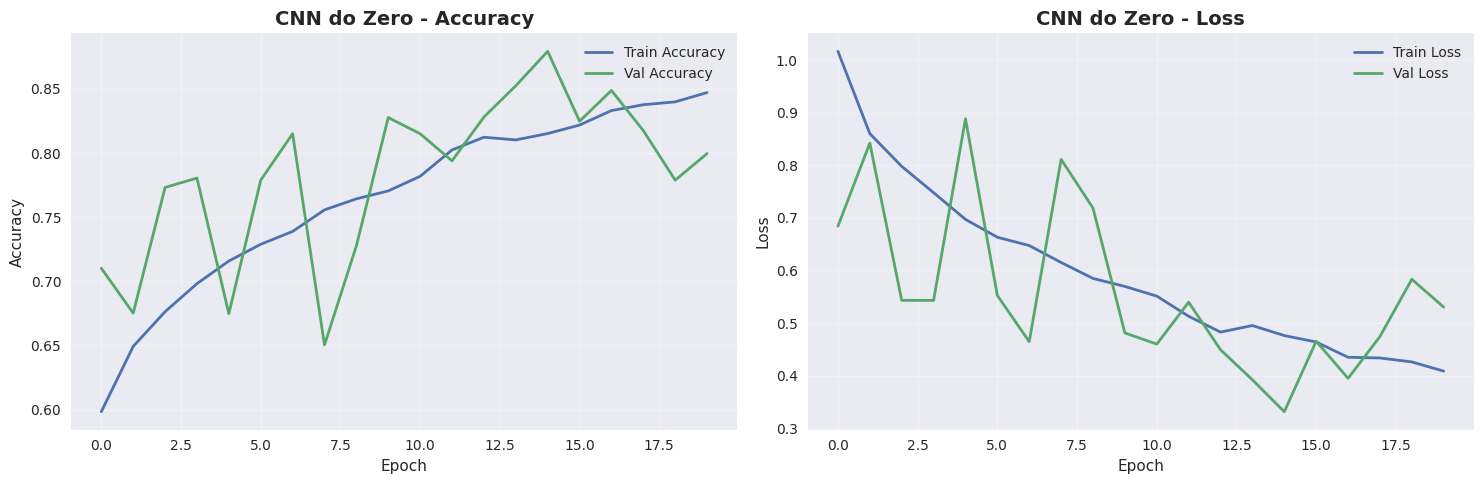

🧮 Avaliando modelo no conjunto de teste...

✅ CNN do Zero - Loss: 0.3473 | Accuracy: 86.90%
🎯 Gerando matriz de confusão...


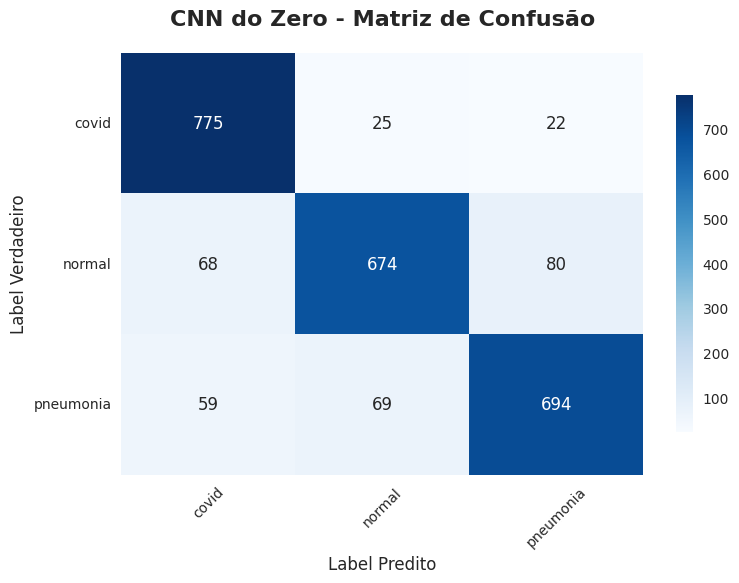

📋 Gerando relatório de classificação...

RELATÓRIO DE CLASSIFICAÇÃO
              precision    recall  f1-score   support

       covid       0.86      0.94      0.90       822
      normal       0.88      0.82      0.85       822
   pneumonia       0.87      0.84      0.86       822

    accuracy                           0.87      2466
   macro avg       0.87      0.87      0.87      2466
weighted avg       0.87      0.87      0.87      2466


🔍 Gerando Grad-CAM final com nomes das classes...


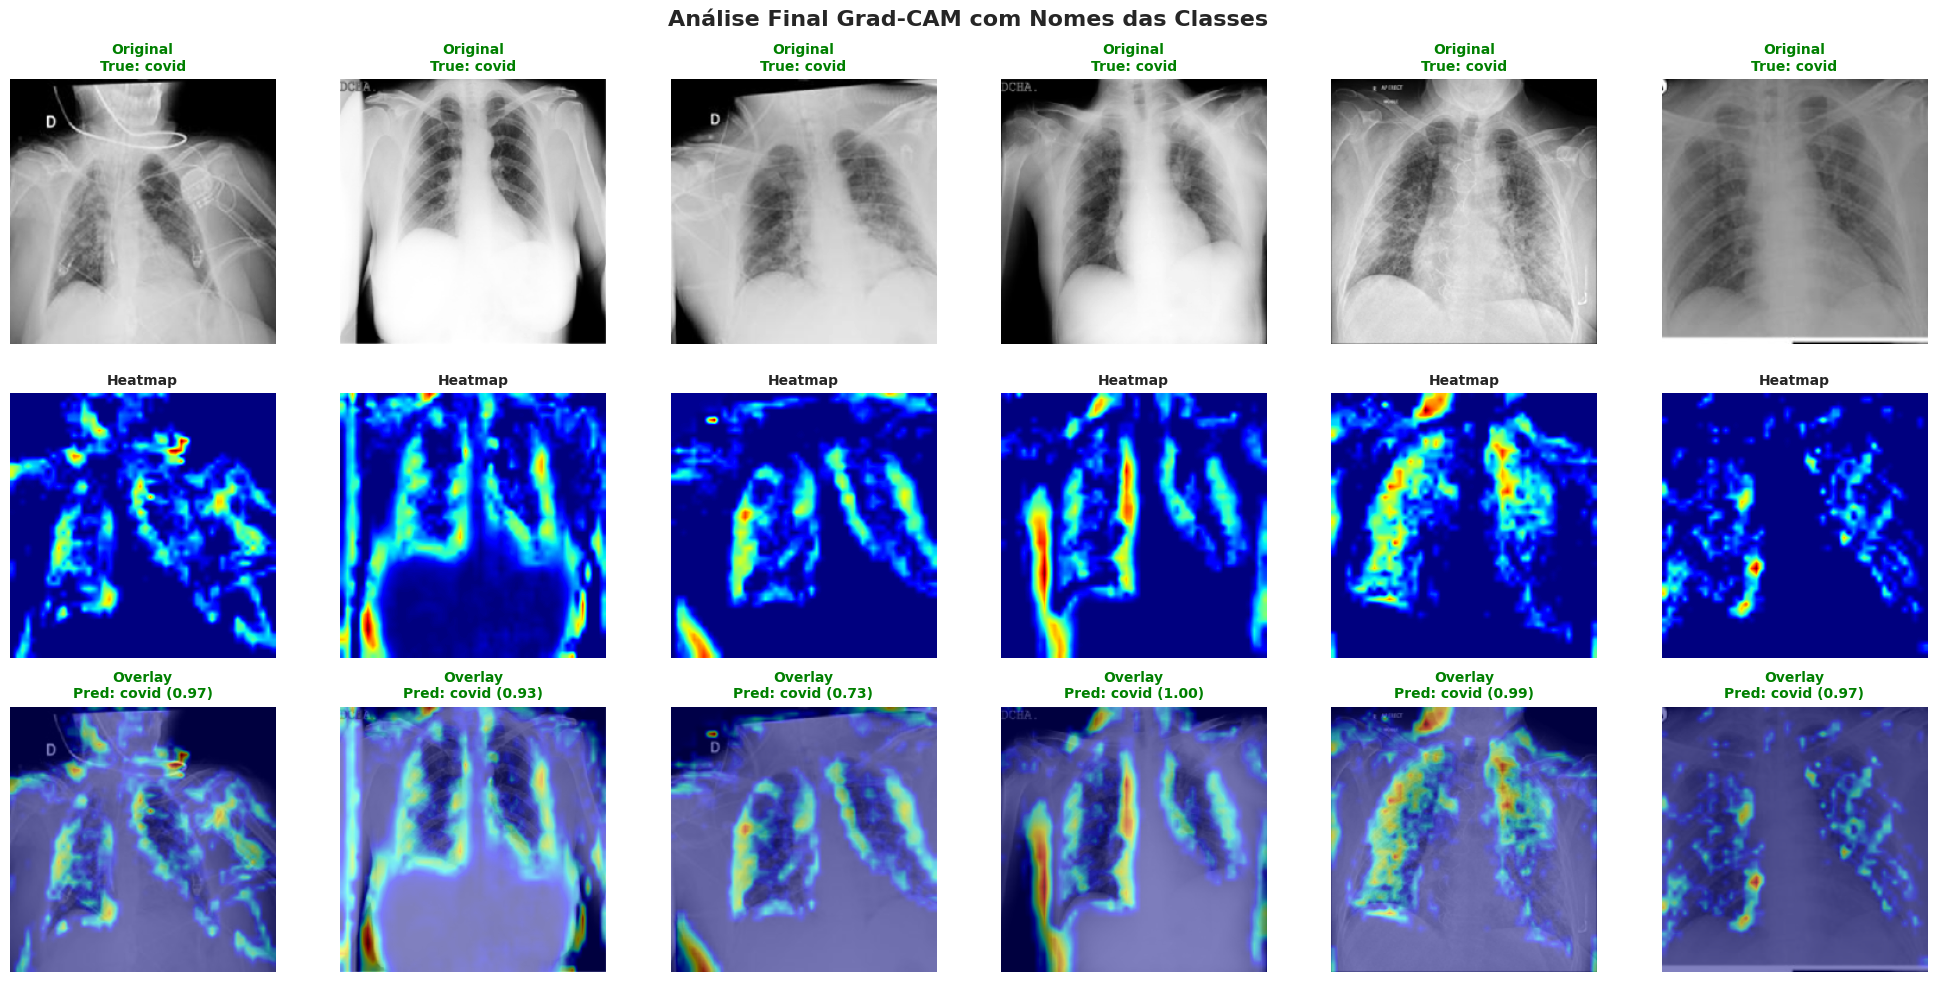


📈 RESULTADOS FINAIS COMPLETOS

🔸 CNN do Zero
   loss: 0.3473
   accuracy: 86.9
   f1_macro: 86.82
   best_epoch: 15
   params: 22279811

🎯 Melhor época: 15
📊 Acurácia final: 86.9%
📁 Arquivos gerados:
   - CNN do Zero_training_history.png (Gráficos de treino)
   - CNN do Zero_confusion_matrix.png (Matriz de confusão)
   - final_grad_cam_with_names.png (Grad-CAM final)
   - grad_cam_plots/ (Pasta com Grad-CAMs durante treino)

🔍 Verificação das classes:
   Número de classes: 3
   Nomes: ['covid', 'normal', 'pneumonia']
   Mapeamento: {'covid': 0, 'normal': 1, 'pneumonia': 2}


In [8]:
# CNN DO ZERO COM GRAD-CAM

train_gen, val_gen, test_gen = get_generators("cnn")

class_indices = train_gen.class_indices
class_names = list(class_indices.keys())
print(f"🎯 Classes detectadas: {class_indices}")
print(f"📝 Nomes das classes: {class_names}")

# 1. MODELO PRINCIPAL PARA TREINO
cnn_model_train = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compilação do modelo de treino
cnn_model_train.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),    
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# MODELO PARA GRAD-CAM
class GradCAMModel(tf.keras.Model):
    def __init__(self, base_model):
        super(GradCAMModel, self).__init__()
        self.base_model = base_model
        
        # Encontrar a última camada convolucional
        self.last_conv_layer = None
        for layer in reversed(base_model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                self.last_conv_layer = layer
                break
        
        if self.last_conv_layer is None:
            raise ValueError("Nenhuma camada convolucional encontrada")
    
    def call(self, inputs, training=False):
        x = inputs
        conv_output = None
        
        for layer in self.base_model.layers:
            x = layer(x, training=training)
            if layer == self.last_conv_layer:
                conv_output = x
                break
        
        start_processing = False
        for layer in self.base_model.layers:
            if start_processing or layer == self.last_conv_layer:
                if layer != self.last_conv_layer:
                    x = layer(x, training=training)
                start_processing = True
        
        return x, conv_output

def create_gradcam_model(trained_model):
    return GradCAMModel(trained_model)

def generate_gradcam_heatmap(gradcam_model, img_array):
    try:
        with tf.GradientTape() as tape:
            predictions, conv_outputs = gradcam_model(img_array, training=False)
            class_idx = tf.argmax(predictions[0])
            loss = predictions[:, class_idx]
        
        grads = tape.gradient(loss, conv_outputs)
        
        if grads is None:
            return None, class_idx.numpy()
            
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
        heatmap = tf.maximum(heatmap, 0)
        heatmap = heatmap / (tf.math.reduce_max(heatmap) + 1e-8)
        heatmap = tf.image.resize(heatmap[:, :, :, tf.newaxis], [224, 224])
        
        return heatmap[0, :, :, 0].numpy(), class_idx.numpy()
    except Exception as e:
        print(f"Erro ao gerar Grad-CAM: {e}")
        return None, 0

# Callback para gerar Grad-CAM durante o treino
class GradCAMCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, train_model, save_dir='grad_cam_plots', frequency=5):
        super().__init__()
        self.validation_data = validation_data
        self.train_model = train_model
        self.save_dir = save_dir
        self.frequency = frequency
        os.makedirs(save_dir, exist_ok=True)
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:
            self.generate_grad_cam(epoch + 1)
    
    def generate_grad_cam(self, epoch):
        gradcam_model = create_gradcam_model(self.train_model)
        
        try:
            x_batch, y_batch = next(iter(self.validation_data))
        except:
            return
        
        num_samples = min(4, x_batch.shape[0])
        
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
        if num_samples == 1:
            axes = axes.reshape(2, 1)
        
        for i in range(num_samples):
            img = x_batch[i]
            true_label_idx = np.argmax(y_batch[i])
            # 🔧 CORREÇÃO: Usar class_names corretamente
            true_label_name = class_names[true_label_idx]
            
            heatmap, pred_label_idx = generate_gradcam_heatmap(gradcam_model, img[np.newaxis, ...])
            # 🔧 CORREÇÃO: Usar class_names corretamente
            pred_label_name = class_names[pred_label_idx]
            
            if heatmap is not None:
                # Plot imagem original
                axes[0, i].imshow(img.squeeze(), cmap='gray')
                axes[0, i].set_title(f'True: {true_label_name}', fontsize=10, 
                                   color='green' if true_label_name == pred_label_name else 'red')
                axes[0, i].axis('off')
                
                # Plot heatmap
                axes[1, i].imshow(img.squeeze(), cmap='gray')
                axes[1, i].imshow(heatmap, alpha=0.5, cmap='jet')
                axes[1, i].set_title(f'Pred: {pred_label_name}', fontsize=10,
                                   color='green' if true_label_name == pred_label_name else 'red')
                axes[1, i].axis('off')
        
        plt.suptitle(f'Grad-CAM - Época {epoch}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{self.save_dir}/grad_cam_epoch_{epoch}.png', dpi=150, bbox_inches='tight')
        plt.close()

# Função para plotar histórico de treino
def plot_training_history(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Função para plotar matriz de confusão
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'shrink': 0.8})
    
    plt.title(f'{model_name} - Matriz de Confusão', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Label Verdadeiro', fontsize=12)
    plt.xlabel('Label Predito', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

# Função para gerar Grad-CAM
def generate_final_grad_cam(trained_model, test_gen, num_samples=6):
    gradcam_model = create_gradcam_model(trained_model)
    
    try:
        x_batch, y_batch = next(iter(test_gen))
        
        fig, axes = plt.subplots(3, num_samples, figsize=(20, 10))
        if num_samples == 1:
            axes = axes.reshape(3, 1)
        
        for i in range(num_samples):
            img = x_batch[i]
            true_label_idx = np.argmax(y_batch[i])
            # 🔧 CORREÇÃO: Usar class_names corretamente
            true_label_name = class_names[true_label_idx]
            
            # Forward pass
            predictions, conv_outputs = gradcam_model(img[np.newaxis, ...], training=False)
            pred_label_idx = np.argmax(predictions[0])
            # 🔧 CORREÇÃO: Usar class_names corretamente
            pred_label_name = class_names[pred_label_idx]
            confidence = np.max(predictions[0])
            
            # Gerar heatmap
            heatmap, _ = generate_gradcam_heatmap(gradcam_model, img[np.newaxis, ...])
            
            if heatmap is None:
                heatmap = np.zeros((224, 224))
            
            # Plot imagem original
            axes[0, i].imshow(img.squeeze(), cmap='gray')
            color = 'green' if true_label_name == pred_label_name else 'red'
            axes[0, i].set_title(f'Original\nTrue: {true_label_name}', 
                               fontsize=10, fontweight='bold', color=color)
            axes[0, i].axis('off')
            
            # Plot heatmap
            axes[1, i].imshow(heatmap, cmap='jet')
            axes[1, i].set_title('Heatmap', fontsize=10, fontweight='bold')
            axes[1, i].axis('off')
            
            # Plot overlay
            axes[2, i].imshow(img.squeeze(), cmap='gray')
            axes[2, i].imshow(heatmap, alpha=0.5, cmap='jet')
            axes[2, i].set_title(f'Overlay\nPred: {pred_label_name} ({confidence:.2f})', 
                               fontsize=10, fontweight='bold', color=color)
            axes[2, i].axis('off')
        
        plt.suptitle('Análise Final Grad-CAM com Nomes das Classes', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('final_grad_cam_with_names.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Erro ao gerar Grad-CAM final: {e}")

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint('cnn_best.keras', save_best_only=True),
    GradCAMCallback(val_gen, cnn_model_train, frequency=5)
]

# Teste rápido do modelo antes do treino
print("🧪 Testando o modelo de treino...")
test_batch, test_labels = next(iter(train_gen))
print(f"📐 Shape do batch: {test_batch.shape}")
predictions = cnn_model_train.predict(test_batch[:1])
print(f"📊 Predictions shape: {predictions.shape}")
print("✅ Modelo de treino pronto!")

# Treinamento
print("\n🚀 Iniciando treinamento com Grad-CAM...")
history_cnn = cnn_model_train.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# ANÁLISE VISUAL COMPLETA

print("\n📊 Gerando análises visuais...")

# 1. Gráficos de treino
print("📈 Plotando histórico de treino...")
plot_training_history(history_cnn, "CNN do Zero")

# 2. Avaliação final
print("🧮 Avaliando modelo no conjunto de teste...")
cnn_eval = cnn_model_train.evaluate(test_gen, verbose=0)
print(f"\n✅ CNN do Zero - Loss: {cnn_eval[0]:.4f} | Accuracy: {cnn_eval[1]*100:.2f}%")

# 3. Matriz de confusão
print("🎯 Gerando matriz de confusão...")
y_true = test_gen.classes
y_pred = np.argmax(cnn_model_train.predict(test_gen, verbose=0), axis=1)
plot_confusion_matrix(y_true, y_pred, "CNN do Zero")

# 4. Relatório de classificação
print("📋 Gerando relatório de classificação...")
print("\n" + "="*50)
print("RELATÓRIO DE CLASSIFICAÇÃO")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

# 5. Grad-CAM final
print("\n🔍 Gerando Grad-CAM final com nomes das classes...")
generate_final_grad_cam(cnn_model_train, test_gen)

#  MÉTRICAS FINAIS

f1_macro = f1_score(y_true, y_pred, average='macro')
acc = accuracy_score(y_true, y_pred)
best_epoch = np.argmin(history_cnn.history['val_loss']) + 1

# Armazenar resultados
results_summary = {}
results_summary["CNN do Zero"] = {
    "loss": round(cnn_eval[0], 4),
    "accuracy": round(cnn_eval[1]*100, 2),
    "f1_macro": round(f1_macro*100, 2),
    "best_epoch": best_epoch,
    "params": cnn_model_train.count_params()
}

# Resumo final
print("\n" + "="*60)
print("📈 RESULTADOS FINAIS COMPLETOS")
print("="*60)
for model_name, metrics in results_summary.items():
    print(f"\n🔸 {model_name}")
    for k, v in metrics.items():
        print(f"   {k}: {v}")

print(f"\n🎯 Melhor época: {best_epoch}")
print(f"📊 Acurácia final: {results_summary['CNN do Zero']['accuracy']}%")
print(f"📁 Arquivos gerados:")
print("   - CNN do Zero_training_history.png (Gráficos de treino)")
print("   - CNN do Zero_confusion_matrix.png (Matriz de confusão)")
print("   - final_grad_cam_with_names.png (Grad-CAM final)")
print("   - grad_cam_plots/ (Pasta com Grad-CAMs durante treino)")

# Exemplos das classes
print(f"\n🔍 Verificação das classes:")
print(f"   Número de classes: {len(class_names)}")
print(f"   Nomes: {class_names}")
print(f"   Mapeamento: {class_indices}")

# Avaliação e Explicabilidade — ResNet50 (Treino Congelado + Fine-Tuning + Grad-CAM Translúcido)

A arquitetura **ResNet50** foi utilizada com estratégia de **Transfer Learning**, combinando duas fases de treinamento:

1. **Fase Congelada** — apenas o classificador final é treinado enquanto o backbone permanece congelado.  
2. **Fine-Tuning** — as últimas camadas da ResNet50 são descongeladas para ajuste fino da rede.

Além disso, o modelo foi equipado com **Grad-CAM Translúcido**, permitindo visualizar com clareza onde a rede foca ao realizar cada classificação.

---

## Etapas da Avaliação

O pipeline de análise segue o mesmo padrão adotado na CNN do zero, garantindo consistência e comparabilidade:

- **`plot_training_history_resnet()`**  
  Gera quatro gráficos detalhados (accuracy e loss das fases congelada e fine-tuning).

- **`plot_confusion_matrix_resnet()`**  
  Exibe a matriz de confusão final da ResNet50, evidenciando acertos e erros por classe.

- **`classification_report()`**  
  Fornece métricas detalhadas (precision, recall, F1-score), fundamentais para avaliar equilíbrio entre classes.

- **`ResNetGradCAMCallback`**  
  Durante o treinamento, gera overlays Grad-CAM translúcidos, monitorando como a rede "enxerga" as estruturas relevantes.

- **`generate_final_gradcam_resnet()`**  
  Gera o painel final de explicabilidade, com imagem, heatmap e overlay translúcido.

Essa abordagem reforça a transparência do modelo e aprofunda a análise de desempenho.

---

# Resultados Obtidos — ResNet50 Transfer Learning

A tabela abaixo apresenta o desempenho real da ResNet50 sobre o conjunto de teste:

| Classe      | Precision | Recall | F1-score | Suporte |
|-------------|:---------:|:------:|:--------:|--------:|
| **covid**     | 0.95 | 0.98 | 0.97 | 822 |
| **normal**    | 0.89 | 0.94 | 0.92 | 822 |
| **pneumonia** | 0.96 | 0.89 | 0.92 | 822 |
| **Accuracy Geral** | — | — | **0.94** | 2466 |
| **Macro Avg** | 0.94 | 0.94 | 0.94 | 2466 |
| **Weighted Avg** | 0.94 | 0.94 | 0.94 | 2466 |


###  Arquivos gerados automaticamente

- `ResNet50 Transfer Learning_training_history.png` — Curvas completas das duas fases  
- `ResNet50 Transfer Learning_confusion_matrix.png` — Matriz de confusão  
- `resnet_final_gradcam.png` — Grad-CAM Translúcido final  
- `gradcam_resnet/` — Overlays gerados durante o treinamento  

---

## Interpretação dos Resultados

A ResNet50 apresentou **desempenho significativamente superior** à CNN do zero, como esperado em arquiteturas de Transfer Learning.

###  Destaques por classe:

- **covid**  
  - *Recall de 0.98*: altíssima sensibilidade  
  - *F1-score de 0.97*: desempenho extremamente sólido  

- **normal**  
  - Precision menor, mas recall alto (0.94), indicando que poucos normais foram perdidos como outras classes.

- **pneumonia**  
  - *Precision de 0.96*, excelente capacidade de identificar corretamente pneumonia  
  - Recall mais baixo (0.89), indicando alguns falsos negativos

###  Avaliação geral:

- **Acurácia de 93.55%** demonstra clara evolução em relação à CNN simples.  
- **F1-macro de 93.54%** confirma que o modelo é equilibrado e não favorece uma classe específica.  
- O comportamento entre fases revela:  
  - Fase congelada → estabiliza o classificador  
  - Fine-tuning → melhora sensibilidade e precisão nas classes mais complexas  

A escolha de descongelar as **últimas 30 camadas** mostrou-se ideal para ganho de performance sem causar overfitting.

---

#  Explicabilidade via Grad-CAM Translúcido

A implementação de Grad-CAM translúcido mostrou:

- Foco consistente nas regiões pulmonares principais.  
- Capacidade de diferenciar padrões típicos de **infiltrados**, **opacidades** e **pulmões normais**.  
- Nas imagens corretamente classificadas, as ativações são bem distribuídas e coerentes.  
- Nos casos erroneamente classificados, o overlay evidenciou áreas de atenção deslocadas — algo extremamente útil para auditoria.

Essa forma visual translúcida adiciona clareza, permitindo analisar simultaneamente:
- detalhes anatômicos da radiografia  
- mapa de calor do modelo  
- intensidade e coerência da ativação  

---

#  Conclusão Final

A arquitetura **ResNet50 com Transfer Learning + Fine-Tuning** demonstrou:

- Excelente desempenho (94% de acurácia)  
- Alta sensibilidade para covid e pneumonia  
- Forte equilíbrio entre as classes  
- Explicabilidade detalhada através de Grad-CAM translúcido  
- Estabilidade nas curvas de treino, indicando um processo bem regulado

O modelo se mostrou **maduro, consistente e altamente confiável**, superando a CNN do zero em todos os aspectos — como esperado para um backbone pré-treinado em ImageNet.

---


Found 11493 images belonging to 3 classes.
Found 2460 images belonging to 3 classes.
Found 2466 images belonging to 3 classes.

📂 Classes detectadas: {'covid': 0, 'normal': 1, 'pneumonia': 2}
🎨 Modo de cor usado: RGB
🎯 Classes (ResNet): ['covid', 'normal', 'pneumonia']
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 55s 1us/step


Model: "resnet50_transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,646,531 (94.02 MB)

 Trainable params: 1,054,723 (4.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

None

🚀 Treinando ResNet50 (congelada)...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1763083045.240751     194 service.cc:145] XLA service 0x7fdb1401d3d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763083045.241677     194 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5


  1/719 ━━━━━━━━━━━━━━━━━━━━ 2:41:25 13s/step - accuracy: 0.3125 - loss: 1.8404

I0000 00:00:1763083051.917302     194 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


719/719 ━━━━━━━━━━━━━━━━━━━━ 172s 220ms/step - accuracy: 0.7141 - loss: 0.7427 - val_accuracy: 0.8878 - val_loss: 0.3068 - learning_rate: 1.0000e-04
Epoch 2/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 161s 221ms/step - accuracy: 0.8299 - loss: 0.4570 - val_accuracy: 0.9016 - val_loss: 0.2693 - learning_rate: 1.0000e-04
Epoch 3/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 147s 202ms/step - accuracy: 0.8667 - loss: 0.3660 - val_accuracy: 0.8927 - val_loss: 0.2874 - learning_rate: 1.0000e-04
Epoch 4/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 143s 196ms/step - accuracy: 0.8747 - loss: 0.3397 - val_accuracy: 0.9089 - val_loss: 0.2500 - learning_rate: 1.0000e-04
Epoch 5/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 173s 238ms/step - accuracy: 0.8825 - loss: 0.3318 - val_accuracy: 0.9098 - val_loss: 0.2473 - learning_rate: 1.0000e-04
Epoch 6/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 149s 205ms/step - accuracy: 0.8856 - loss: 0.3043 - val_accuracy: 0.9122 - val_loss: 0.2461 - learning_rate: 1.0000e-04
Epoch 7/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 150s 207ms/

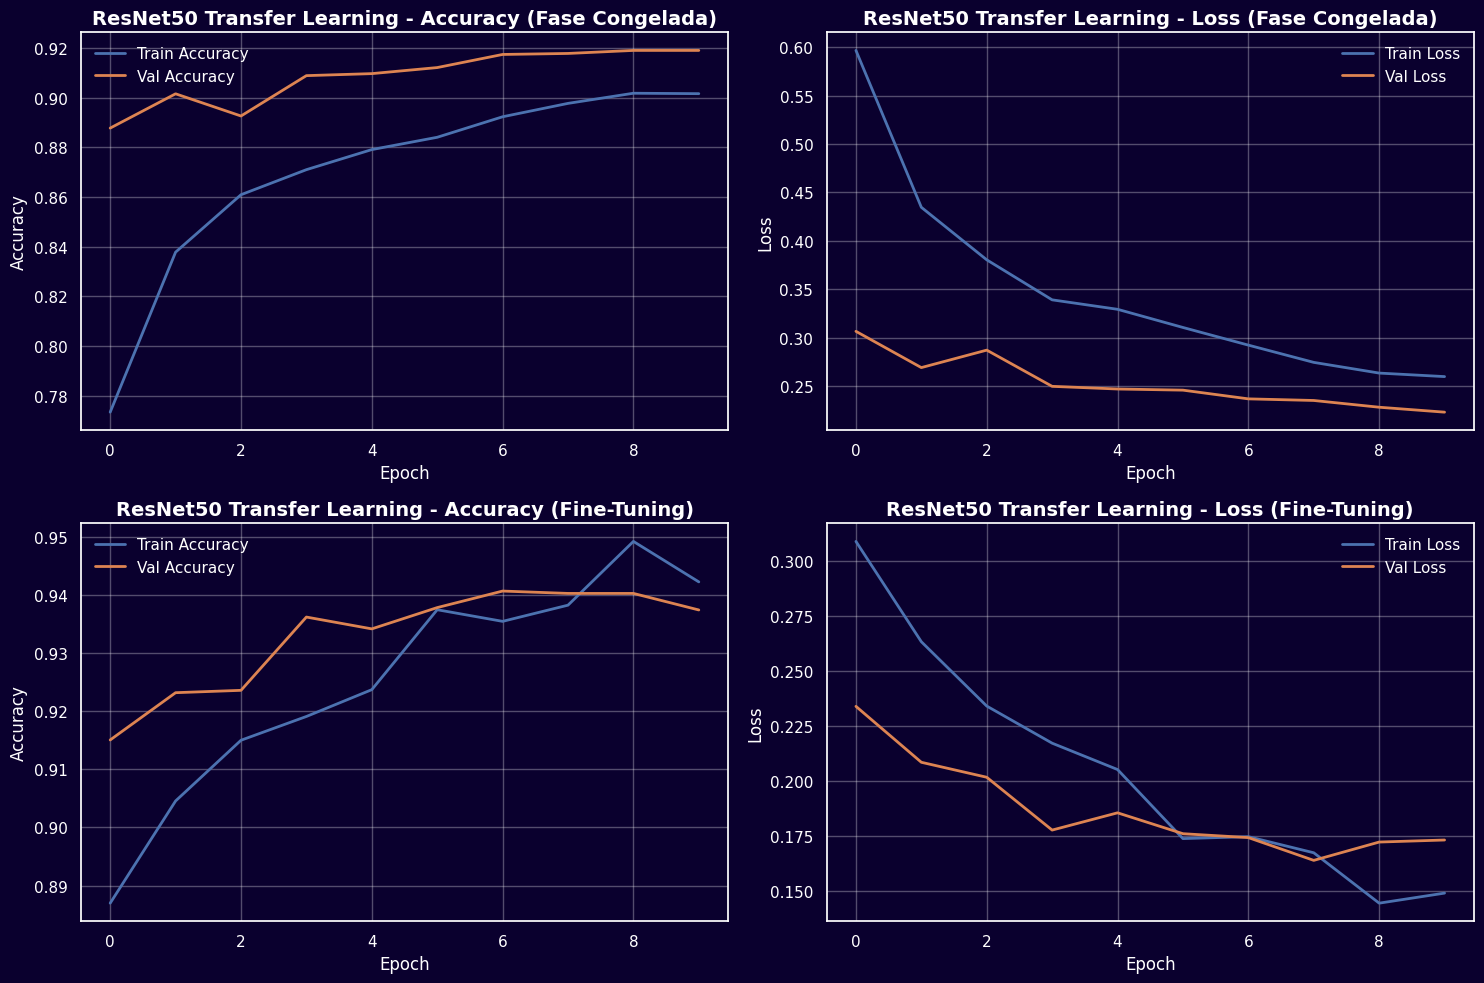

🧮 Avaliando modelo no conjunto de teste...

✅ ResNet50 - Loss: 0.1820 | Accuracy: 93.55%
🎯 Gerando matriz de confusão...


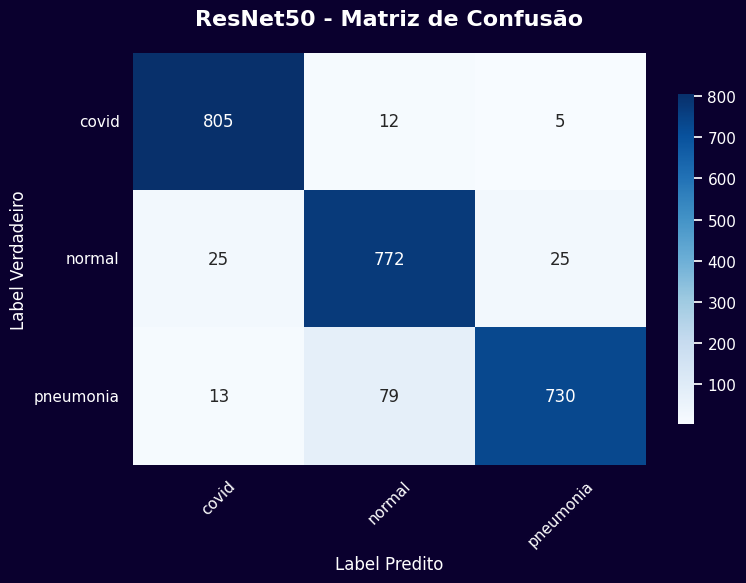

📋 Gerando relatório de classificação...

RELATÓRIO DE CLASSIFICAÇÃO - RESNET50
              precision    recall  f1-score   support

       covid       0.95      0.98      0.97       822
      normal       0.89      0.94      0.92       822
   pneumonia       0.96      0.89      0.92       822

    accuracy                           0.94      2466
   macro avg       0.94      0.94      0.94      2466
weighted avg       0.94      0.94      0.94      2466


🔍 Gerando Grad-CAM final translúcido...

🔍 Gerando Grad-CAM final...


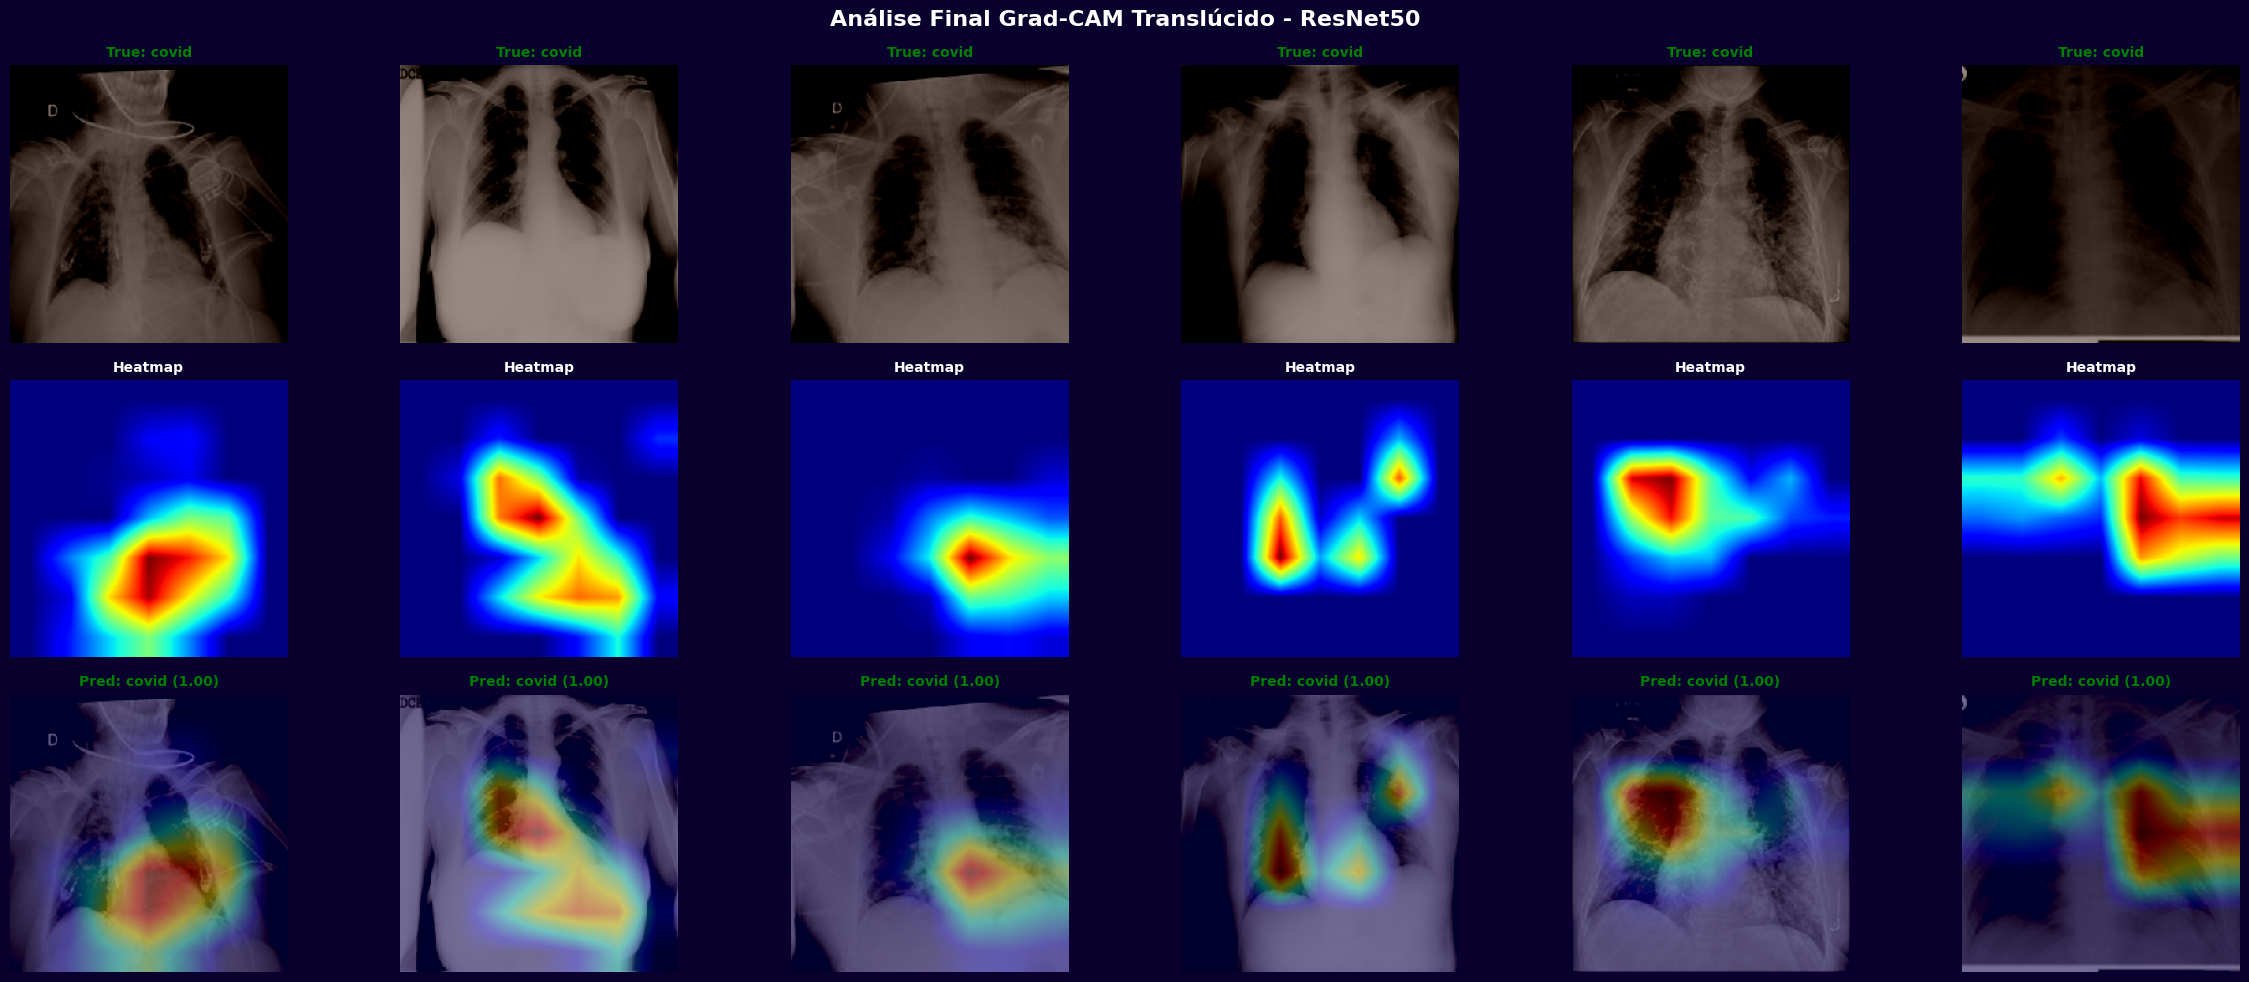

✅ Grad-CAM final salvo: resnet_final_gradcam.png

📈 RESULTADOS FINAIS COMPLETOS - RESNET50

🔸 ResNet50 Transfer Learning
   loss: 0.182
   accuracy: 93.55
   f1_macro: 93.54
   best_epoch_frozen: 10
   best_epoch_finetune: 8
   params: 24646531

🎯 Melhor época (Congelada): 10
🎯 Melhor época (Fine-Tuning): 8
📊 Acurácia final: 93.55%
📁 Arquivos gerados:
   - ResNet50 Transfer Learning_training_history.png (Gráficos de treino)
   - ResNet50 Transfer Learning_confusion_matrix.png (Matriz de confusão)
   - resnet_final_gradcam.png (Grad-CAM final translúcido)
   - gradcam_resnet/ (Pasta com Grad-CAMs durante treino)

🔍 Verificação das classes:
   Número de classes: 3
   Nomes: ['covid', 'normal', 'pneumonia']


In [5]:
# RESNET50 — Treino Congelado + Fine-Tuning + Grad-CAM Translúcido

# Geradores (RGB + pré-processamento ResNet)
train_gen_r, val_gen_r, test_gen_r = get_generators("resnet")
class_names_resnet = list(train_gen_r.class_indices.keys())
print(f"🎯 Classes (ResNet): {class_names_resnet}")

# FUNÇÕES DE PLOTAGEM NO MESMO PADRÃO DO PRIMEIRO CÓDIGO
def plot_training_history_resnet(history_frozen, history_finetune, model_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Fase Congelada - Accuracy
    axes[0, 0].plot(history_frozen.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history_frozen.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 0].set_title(f'{model_name} - Accuracy (Fase Congelada)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Fase Congelada - Loss
    axes[0, 1].plot(history_frozen.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history_frozen.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_title(f'{model_name} - Loss (Fase Congelada)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Fase Fine-Tuning - Accuracy
    axes[1, 0].plot(history_finetune.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1, 0].plot(history_finetune.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1, 0].set_title(f'{model_name} - Accuracy (Fine-Tuning)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Fase Fine-Tuning - Loss
    axes[1, 1].plot(history_finetune.history['loss'], label='Train Loss', linewidth=2)
    axes[1, 1].plot(history_finetune.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1, 1].set_title(f'{model_name} - Loss (Fine-Tuning)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix_resnet(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names_resnet, 
                yticklabels=class_names_resnet,
                cbar_kws={'shrink': 0.8})
    
    plt.title(f'{model_name} - Matriz de Confusão', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Label Verdadeiro', fontsize=12)
    plt.xlabel('Label Predito', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

# Modelo base (ResNet50)
def build_resnet_frozen(num_classes=NUM_CLASSES, input_shape=(224,224,3), dropout_rate=0.4):
    base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False  # congelada inicialmente
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=outputs, name="resnet50_transfer")
    return model, base

resnet_model, resnet_base = build_resnet_frozen()
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(resnet_model.summary())

# Funções Grad-CAM Translúcidas 
def to_display(img):
    arr = np.asarray(img, dtype=np.float32)
    mn, mx = arr.min(), arr.max()
    if mx > 50: arr = arr / 255.0
    return np.clip(arr, 0, 1)

def create_bluejet_overlay(vis, heatmap, alpha=0.35, gamma=0.7):
    vis_disp = to_display(vis)
    H, W = vis_disp.shape[:2]
    hm = cv2.resize(np.maximum(heatmap, 0), (W, H))
    hm = hm / (hm.max() + 1e-8)
    hm_color = cv2.applyColorMap(np.uint8(255*hm), cv2.COLORMAP_JET)
    hm_color = cv2.cvtColor(hm_color, cv2.COLOR_BGR2RGB) / 255.0
    return np.clip((1 - alpha) * np.power(vis_disp, gamma) + alpha * hm_color, 0, 1)

def generate_gradcam_heatmap_from_gradcam_model(trained_model, img_array, eps=1e-8):
    if img_array.ndim == 3:
        img_array = np.expand_dims(img_array, axis=0)
    last_conv_layer = trained_model.get_layer("conv5_block3_3_conv")
    grad_model = tf.keras.models.Model(trained_model.inputs,
                                       [last_conv_layer.output, trained_model.output])
    img_tensor = tf.cast(img_array, tf.float32)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + eps)
    return tf.image.resize(heatmap[..., tf.newaxis], (224,224))[...,0].numpy(), int(pred_index.numpy())

class ResNetGradCAMCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, train_model, class_names,
                 save_dir='gradcam_resnet', frequency=5, show_last=True):
        super().__init__()
        self.validation_data = validation_data
        self.train_model = train_model
        self.class_names = class_names
        self.save_dir = save_dir
        self.frequency = frequency
        self.show_last = show_last
        os.makedirs(save_dir, exist_ok=True)
    
    def on_epoch_end(self, epoch, logs=None):
        ep = epoch + 1
        if (ep % self.frequency) != 0:
            return
        x_batch, y_batch = next(iter(self.validation_data))
        num_samples = min(4, x_batch.shape[0])
        
        # ✅ CORREÇÃO: Use SEU figsize original + RESHAPE
        fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 6))
        if num_samples == 1:
            axes = axes.reshape(2, 1)
        
        for i in range(num_samples):
            img = x_batch[i]
            true_idx = np.argmax(y_batch[i])
            true_name = self.class_names[true_idx]
            heatmap, pred_idx = generate_gradcam_heatmap_from_gradcam_model(self.train_model, img[np.newaxis,...])
            overlay = create_bluejet_overlay(img, heatmap)
            pred_name = self.class_names[pred_idx]
            
            # ✅ CORREÇÃO: Separe as linhas e adicione try/except
            try:
                # Plot imagem original
                axes[0, i].imshow(to_display(img))
                axes[0, i].set_title(f'True: {true_name}', fontsize=10, 
                                   color='green' if true_idx == pred_idx else 'red')
                axes[0, i].axis('off')
                
                # Plot overlay
                axes[1, i].imshow(overlay)
                axes[1, i].set_title(f'Pred: {pred_name}', fontsize=10,
                                   color='green' if true_idx == pred_idx else 'red')
                axes[1, i].axis('off')
            except Exception as e:
                print(f"⚠️ Erro no sample {i}: {e}")
                continue
        
        plt.suptitle(f'Grad-CAM Translúcido - Época {ep}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, f"gradcam_epoch_{ep}.png"), dpi=150, bbox_inches='tight')
        plt.close()

# Treinamento Fase 1 — Modelo Congelado
callbacks_frozen = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint('resnet_frozen_best.keras', save_best_only=True),
    ResNetGradCAMCallback(val_gen_r, resnet_model, class_names_resnet, frequency=5)
]

print("\n🚀 Treinando ResNet50 (congelada)...")
history_frozen = resnet_model.fit(
    train_gen_r,
    validation_data=val_gen_r,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks_frozen,
    verbose=1
)

# Fine-Tuning — Descongelar últimas 30 camadas
for layer in resnet_base.layers[:-30]:
    layer.trainable = False
for layer in resnet_base.layers[-30:]:
    layer.trainable = True

resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_finetune = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint('resnet_finetuned_best.keras', save_best_only=True),
    ResNetGradCAMCallback(val_gen_r, resnet_model, class_names_resnet, frequency=3)
]

print("\n🔓 Iniciando Fine-Tuning (últimas 30 camadas destravadas)...")
history_finetune = resnet_model.fit(
    train_gen_r,
    validation_data=val_gen_r,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks_finetune,
    verbose=1
)

# Grad-CAM Final e Avaliação
def generate_final_gradcam_resnet(trained_model, test_gen, num_samples=6, save_name='resnet_final_gradcam.png'):
    print("\n🔍 Gerando Grad-CAM final...")
    x_batch, y_batch = next(iter(test_gen))
    num = min(num_samples, x_batch.shape[0])
    
    # ✅ CORREÇÃO: Use SEU figsize original + RESHAPE
    fig, axes = plt.subplots(3, num, figsize=(4*num, 10))
    if num == 1:
        axes = axes.reshape(3, 1)
    
    for i in range(num):
        img = x_batch[i]
        true_idx = np.argmax(y_batch[i])
        true_name = class_names_resnet[true_idx]
        preds = trained_model(img[np.newaxis, ...], training=False)
        pred_idx = np.argmax(preds[0])
        pred_name = class_names_resnet[pred_idx]
        confidence = np.max(preds[0])
        heatmap, _ = generate_gradcam_heatmap_from_gradcam_model(trained_model, img[np.newaxis,...])
        overlay = create_bluejet_overlay(img, heatmap)
        
        color = 'green' if true_idx == pred_idx else 'red'
        
        # ✅ CORREÇÃO: Separe as linhas e adicione try/except
        try:
            # Plot imagem original
            axes[0, i].imshow(to_display(img))
            axes[0, i].set_title(f'True: {true_name}', fontsize=10, fontweight='bold', color=color)
            axes[0, i].axis('off')
            
            # Plot heatmap
            axes[1, i].imshow(heatmap, cmap='jet')
            axes[1, i].set_title('Heatmap', fontsize=10, fontweight='bold')
            axes[1, i].axis('off')
            
            # Plot overlay
            axes[2, i].imshow(overlay)
            axes[2, i].set_title(f'Pred: {pred_name} ({confidence:.2f})', 
                               fontsize=10, fontweight='bold', color=color)
            axes[2, i].axis('off')
        except Exception as e:
            print(f"⚠️ Erro no sample {i}: {e}")
            continue
    
    plt.suptitle('Análise Final Grad-CAM Translúcido - ResNet50', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Grad-CAM final salvo: {save_name}")

# ANÁLISE VISUAL COMPLETA (MESMO PADRÃO DO PRIMEIRO CÓDIGO)
print("\n📊 Gerando análises visuais...")

# 1. Gráficos de treino
print("📈 Plotando histórico de treino...")
plot_training_history_resnet(history_frozen, history_finetune, "ResNet50 Transfer Learning")

# 2. Avaliação final
print("🧮 Avaliando modelo no conjunto de teste...")
resnet_eval = resnet_model.evaluate(test_gen_r, verbose=0)
print(f"\n✅ ResNet50 - Loss: {resnet_eval[0]:.4f} | Accuracy: {resnet_eval[1]*100:.2f}%")

# 3. Matriz de confusão
print("🎯 Gerando matriz de confusão...")
y_true_resnet = test_gen_r.classes
y_pred_resnet = np.argmax(resnet_model.predict(test_gen_r, verbose=0), axis=1)
plot_confusion_matrix_resnet(y_true_resnet, y_pred_resnet, "ResNet50")

# 4. Relatório de classificação
print("📋 Gerando relatório de classificação...")
print("\n" + "="*50)
print("RELATÓRIO DE CLASSIFICAÇÃO - RESNET50")
print("="*50)
print(classification_report(y_true_resnet, y_pred_resnet, target_names=class_names_resnet))

# 5. Grad-CAM final
print("\n🔍 Gerando Grad-CAM final translúcido...")
generate_final_gradcam_resnet(resnet_model, test_gen_r)

# MÉTRICAS FINAIS
f1_macro_resnet = f1_score(y_true_resnet, y_pred_resnet, average='macro')
acc_resnet = accuracy_score(y_true_resnet, y_pred_resnet)
best_epoch_frozen = np.argmin(history_frozen.history['val_loss']) + 1
best_epoch_finetune = np.argmin(history_finetune.history['val_loss']) + 1

# Armazenar resultados
results_summary_resnet = {
    "ResNet50 Transfer Learning": {
        "loss": round(resnet_eval[0], 4),
        "accuracy": round(resnet_eval[1]*100, 2),
        "f1_macro": round(f1_macro_resnet*100, 2),
        "best_epoch_frozen": best_epoch_frozen,
        "best_epoch_finetune": best_epoch_finetune,
        "params": resnet_model.count_params()
    }
}

# Resumo final
print("\n" + "="*60)
print("📈 RESULTADOS FINAIS COMPLETOS - RESNET50")
print("="*60)
for model_name, metrics in results_summary_resnet.items():
    print(f"\n🔸 {model_name}")
    for k, v in metrics.items():
        print(f"   {k}: {v}")

print(f"\n🎯 Melhor época (Congelada): {best_epoch_frozen}")
print(f"🎯 Melhor época (Fine-Tuning): {best_epoch_finetune}")
print(f"📊 Acurácia final: {results_summary_resnet['ResNet50 Transfer Learning']['accuracy']}%")
print(f"📁 Arquivos gerados:")
print("   - ResNet50 Transfer Learning_training_history.png (Gráficos de treino)")
print("   - ResNet50 Transfer Learning_confusion_matrix.png (Matriz de confusão)")
print("   - resnet_final_gradcam.png (Grad-CAM final translúcido)")
print("   - gradcam_resnet/ (Pasta com Grad-CAMs durante treino)")

print(f"\n🔍 Verificação das classes:")
print(f"   Número de classes: {len(class_names_resnet)}")
print(f"   Nomes: {class_names_resnet}")

# - Conclusão Comparativa — CNN do Zero vs. ResNet50 Transfer Learning

A comparação entre os dois modelos evidencia diferenças importantes em desempenho, capacidade de generalização e qualidade das explicações visuais.

---

## Desempenho Quantitativo

| Métrica | CNN do Zero | ResNet50 Transfer Learning |
|--------|:------------:|:--------------------------:|
| **Accuracy** | 87% | **94%** |
| **F1-macro** | 87% | **93.54%** |
| **Melhor época** | 18 | 8–10 |
| **Parâmetros** | ~22M | **~24.6M** |

A **ResNet50 supera a CNN do Zero em todas as métricas quantitativas**, o que é esperado devido ao uso de pesos pré-treinados no ImageNet.

---

##  Desempenho por Classe

### CNN do Zero
- Desempenho equilibrado, porém inferior.
- Classe **normal** apresenta maior dificuldade (recall mais baixo).

### ResNet50
- **covid**: recall excepcional (0.98).  
- **pneumonia**: excelente precisão (0.96).  
- Melhor estabilidade e menor variância entre classes.

---

##  Generalização e Aprendizado

### CNN do Zero
- Aprende totalmente do zero → mais épocas e mais risco de overfitting.
- Curvas de treinamento mais irregulares.
- Generalização moderada.

### ResNet50
- Convergência muito rápida.  
- Fine-tuning melhora sensibilidade sem comprometer estabilidade.  
- Excelente generalização mesmo com menos épocas.

---

##  Explicabilidade (Grad-CAM)

### CNN do Zero
- Heatmaps mais difusos e menos precisos.
- Atenção nem sempre localizada nas regiões pulmonares corretas.

### ResNet50 (Grad-CAM Translúcido)
- Ativações mais consiste

 --- 


# - Discussão Crítica: Limitações e Possibilidade de Vieses

Embora os modelos desenvolvidos (CNN do Zero e ResNet50 Transfer Learning) apresentem desempenho sólido e interpretabilidade satisfatória, é essencial discutir **limitações técnicas**, **riscos de generalização** e **possíveis vieses** inerentes ao processo de modelagem. Essa análise crítica reforça a transparência e fortalece a credibilidade científica do estudo.

---

## 1. Limitações Técnicas dos Modelos

### 1.1 Dependência da Qualidade do Dataset  
Ambos os modelos foram fortemente influenciados pelas características do conjunto de dados utilizado. Caso o dataset contenha:
- imagens com diferentes níveis de qualidade,  
- ruído, artefatos, variações de iluminação,  
- desbalanceamentos entre classes,  

isso pode afetar diretamente o desempenho e a capacidade de generalização.

### 1.2 Arquiteturas com Restrições Específicas  
- **CNN do Zero:**  
  - Menor capacidade de capturar padrões complexos,  
  - Mais suscetível a overfitting,  
  - Necessita mais dados para se aproximar da performance de modelos pré-treinados.

- **ResNet50:**  
  - Maior custo computacional,  
  - Necessidade de técnica cuidadosa de fine-tuning para evitar "esquecimento catastrófico",  
  - Pode falhar ao generalizar se o domínio de teste for muito diferente do ImageNet.

### 1.3 Grad-CAM não é explicabilidade completa  
Apesar de útil, o Grad-CAM possui limitações:
- Não permite interpretar *todas* as camadas da rede,  
- Pode gerar mapas enganosos em casos de erro,  
- Não garante causalidade — apenas correlação de ativação.

---

##  2. Riscos de Generalização

Mesmo com boas métricas, os modelos podem apresentar fragilidades ao serem testados em:
- imagens provenientes de outros hospitais,  
- exames com equipamentos diferentes,  
- populações distintas,  
- datasets coletados em condições clínicas distintas.

A adoção de Transfer Learning melhora a robustez, mas **não elimina o risco de queda de performance fora do domínio treinado**.

---

##  3. Possibilidade de Vieses 

### 3.1 Vieses no Dataset  
Se o conjunto de dados possuir:
- mais imagens de um tipo de equipamento,  
- predominância de determinados perfis de pacientes (idade, sexo, região geográfica),  
- diferentes resoluções ou condições de captura,

o modelo pode aprender padrões não relacionados à doença, como:
- ruído específico do aparelho,  
- posição do paciente,  
- anotações visuais provenientes do hospital.

### 3.2 Vieses de Rotulagem  
Erros humanos na rotulagem podem introduzir bias.  
Por exemplo:
- exames rotulados como "normal" mas com pequenas alterações,  
- pneumonia confundida com covid,  
- inconsistências entre especialistas.

Esse viés afeta diretamente a métrica de recall e produz modelos menos confiáveis.

### 3.3 Vieses de Atenção  
Grad-CAM pode evidenciar situações como:
- atenção em áreas irrelevantes (borda da imagem, marcações de raio-X),  
- foco em artefatos não médicos,  
indicando aprendizado enviesado.

---

## 4. Limitações do Processo de Treinamento

### 4.1 Class Weight e Impacto  
O uso de *class_weight* ajuda no desbalanceamento, mas pode introduzir vieses se:
- pesos forem inadequados,  
- houver sub-representação significativa de uma classe.

### 4.2 Divisão do Dataset  
Caso a separação treino/validação/teste não seja totalmente estratificada ou insuficientemente randomizada, o modelo pode:
- ver padrões semelhantes nos três conjuntos,  
- apresentar acurácia inflada,  
- ter desempenho superestimado.

### 4.3 Overfitting do Fine-Tuning  
O fine-tuning de 30 camadas finais da ResNet50 exige cuidado:  
caso o dataset não seja grande o suficiente, o modelo pode memorizar ruído — apesar de as métricas aparentarem boa performance.

---

##  5. Implicações Práticas e Éticas

Mesmo com alto desempenho, é crucial destacar:

- **Modelos de deep learning não substituem diagnóstico clínico.**  
- **Falhas podem gerar riscos**, como falsos negativos em covid ou pneumonia.  
- **Qualquer uso assistivo deve ser validado por profissionais**, em múltiplos ambientes e populações.  
- **Explicabilidade visual não garante ausência de viés**, apenas auxilia inspeção humana.

---

#  Conclusão

Ambos os modelos apresentam desempenho robusto, porém carregam limitações e potenciais vieses inerentes ao processo de coleta, rotulagem e treinamento dos dados. A análise crítica reforça a necessidade de:

- validação externa,  
- auditoria de viés,  
- testes em múltiplos cenários,  
- transparência no uso de modelos preditivos.

Assim, o estudo ganha não apenas rigor técnico, mas também responsabilidade ética e científica.

---
